# Packages

In [1]:
import numpy as np
from scipy.ndimage.filters import uniform_filter
from scipy.optimize import root
from functools import reduce
from scipy.signal import correlate
from scipy.interpolate import interp1d

from shapely.geometry import LineString, Polygon, Point

from zipfile import ZipFile
import xml.sax, xml.sax.handler
from pyproj import Proj, transform
from osgeo import gdal

import pandas as pd
import time
import datetime

import pickle
from pathlib import Path

from descartes import PolygonPatch
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from matplotlib.collections import PatchCollection, LineCollection
from matplotlib.patches import Rectangle
from matplotlib.ticker import NullFormatter
%matplotlib inline
plt.rcParams['text.usetex'] = True #Let TeX do the typsetting
plt.rcParams['text.latex.preamble'] = [r'\usepackage{sansmath}', r'\sansmath'] #Force sans-serif math mode (for axes labels)
plt.rcParams['font.family'] = 'sans-serif' # ... for regular text
plt.rcParams['font.sans-serif'] = 'Helvetica' # Choose a nice font here
fs = 8

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# Constants

In [322]:
s2y = 1/(365*24*60*60)
m2km = 1e-3
m2mm = 1e+3

af0 = 25 # direction clockwise from east in degrees that the dunes move
af0_r = af0*np.pi/180
adelta = 15 # permissible variation around af0 in some calculations

# representative constants
rhos = 2380 # gypsum
rhof = 1.225 # air
grav = 9.81 # gravity
gdia = 300e-6 # aeolian grain diameter
kap  = 0.41 # von karman
z00  = 1e-4 # roughness length of upwind
z01  = 1e-1 # roughness length of downwind
zU   = 10 # height of met tower wind
f    = 7.2921*10**-5*2*np.sin(32.87*np.pi/180) # coriolis frequency at the location

uscr = 0.3 # approximate value (jerolmack et al 2011 use 0.39 and iverson 1987 would be 0.24)
# uscr = (rhos*grav*gdia/rhof)**0.5/10 # iverson et al 1987

In [3]:
dtdz_Uthr = 2.5e-7 # threshold maximum change in dzdt we expect - anything larger would be ~7.9 m/yr
slopethr  = 1e-2 # minimum slope of surfaces included in the flux calculations
repose    = np.tan(30*np.pi/180) # angle of repose is like 34 degrees
dzdtthr   = 1e-8 # threshold minimum change used in the flux calculations
distthr   = 10 # minimum distance that a flux calculation will be integrated over

DS = 500 # meters over which the dune orientation distribution is segmented
stdwidth = 100 # moving box window width in meters over which the elevation standard deviation is calculated
uwimax = 5547 # index where the mutual dem upwind edge first intersects the dunefield upwind boundary

dt0 = 21168000 #seconds between jan09 and sep09
dt1 = 21859200 #seconds between sep09 and jun10
dt2 = dt0+dt1  #seconds between jan09 and jun10

dempairs = [[0,1],[1,2],[0,2]]
demdts   = [dt0,dt1,dt2] 

In [4]:
eps = 1e-2 # 1+-eps for speed saturation envelope 

Nt = 1000 # number of timesteps
Ng = 10 # number of forcing steps
Nz = 100 # number of vertical grid cells

phi = 0.74 # packing fraction of sand for landscape evolution
Z = 1000 # Z is the ABL flow height from momen & bou-zeid 2016
L0 = 50 # L0 is the eddy mixing length scale from momen & bou-zeid 2016

z_t = np.logspace(np.log10(1),np.log10(100),Nz) # vertical grid, log-spaced between the 1m and ABL height

T = 60*60*30 # total model time
t_t = np.logspace(0,np.log10(T),Nt) # the time step grid

# Functions

## DEM

In [5]:
###############
## FUNCTION DEFS TO PARSE KMZ ##
###############

class PlacemarkHandler(xml.sax.handler.ContentHandler):
    def __init__(self):
        self.inName = False # handle XML parser events
        self.inPlacemark = False
        self.mapping = {} 
        self.buffer = ""
        self.name_tag = ""
        
    def startElement(self, name, attributes):
        if name == "Placemark": # on start Placemark tag
            self.inPlacemark = True
            self.buffer = "" 
        if self.inPlacemark:
            if name == "name": # on start title tag
                self.inName = True # save name text to follow
            
    def characters(self, data):
        if self.inPlacemark: # on text within tag
            self.buffer += data # save text if in title
            
    def endElement(self, name):
        self.buffer = self.buffer.strip('\n\t')
        
        if name == "Placemark":
            self.inPlacemark = False
            self.name_tag = "" #clear current name
        
        elif name == "name" and self.inPlacemark:
            self.inName = False # on end title tag            
            self.name_tag = self.buffer.strip()
            self.mapping[self.name_tag] = {}
        elif self.inPlacemark:
            if name in self.mapping[self.name_tag]:
                self.mapping[self.name_tag][name] += self.buffer
            else:
                self.mapping[self.name_tag][name] = self.buffer
        self.buffer = ""
        
def build_table(mapping):
    sep = ','
        
    output = 'Name' + sep + 'Coordinates\n'
    points = ''
    lines = ''
    shapes = ''
    for key in mapping:
        coord_str = mapping[key]['coordinates'] + sep
        
        if 'LookAt' in mapping[key]: #points
            points += key + sep + coord_str + "\n"
        elif 'LineString' in mapping[key]: #lines
            lines += key + sep + coord_str + "\n"
        else: #shapes
            shapes += key + sep + coord_str + "\n"
    output += points + lines + shapes
    return output

In [6]:
# fast function to make a moving window that finds the standard deviation of dem within it

def window_std(X, window_size):
    r,c = X.shape
    X+=np.random.rand(r,c)*1e-6 # add some tiny tiny noise because the values are discrete
    c1 = uniform_filter(X, window_size, mode='reflect')
    c2 = uniform_filter(X*X, window_size, mode='reflect')
    return np.sqrt(c2 - c1*c1)

In [7]:
# function to calibrate the dem difference maps because each flight is slightly bias in absolute elevation
# done by linear shift in the dzdt maps such that they all have a net value of zero
# this method is used because the majority of each map is interdune or non-erodible material

def demcorrect(dems,dempairs,demdts):
    binno = 200
    dzdtcs = []
    
    for i in range(len(dempairs)):
        dzdt = (dems[dempairs[i][1]]-dems[dempairs[i][0]])/demdts[i]
        dzdt[np.abs(dzdt)>dtdz_Uthr] = np.nan

        temp = dzdt[~np.isnan(dzdt)]
        dzdtcnt,dzdtbins = np.histogram(temp,bins=np.linspace(np.percentile(temp,2),np.percentile(temp,98),binno))
        dzdtbinmids = dzdtbins[1:] + np.diff(dzdtbins)/2
        
        dzdtcs.append(dzdt - dzdtbinmids[np.argmax(dzdtcnt)])
        
    return dzdtcs

In [8]:
# function to find the sediment flux from a pair of dems
# done by integrating along segments of transects in the along-flux direction (x)
# where each segment is assumed to start with a zero flux boundary

def demflux(dem_i,dem_f,dzdt,x):
    
    qs = np.empty([np.shape(dem_i)[0],np.shape(dem_i)[1]-1])
    qs[:] = np.nan

    dx = np.diff(x)
    
    for i in np.arange(np.shape(dem_i)[0]):
    
        tempy = np.copy(dzdt[i,:])
        tempd0 = np.diff(dem_i[i,:])/dx
        tempd1 = np.diff(dem_f[i,:])/dx
        tempy = tempy[1:]
        
        # get rid of pixels where land in both dems is flat, and the change is not spuriously large
        tempy[(np.abs(tempd0)<slopethr)&(np.abs(tempd1)<slopethr)&(np.abs(tempy)<dzdtthr)] = np.nan

        # only include segments that are at least 10m long
        indso = np.squeeze(np.argwhere(np.isnan(tempy)))
        indsn = []
        for j in np.arange(np.shape(indso)[0]-1):
            if np.diff(indso)[j]<=distthr:
                indsn.append(np.arange(indso[j],indso[j+1]))
        tempy[np.concatenate(indsn).ravel()] = np.nan

        temp1  = np.squeeze(np.argwhere(~np.isnan(tempy)))
        temp1i = temp1[np.squeeze(np.argwhere(np.diff(temp1)!=1))]
        temp2  = np.squeeze(np.argwhere(np.isnan(tempy)))
        temp2i = temp2[np.squeeze(np.argwhere(np.diff(temp2)!=1))]+1

        # do exner on each segment
        if np.shape(temp1i):
            for j in np.arange(np.shape(temp1i)[0]):
                qs[i,temp2i[j]:temp1i[j]+1] = -phi*np.cumsum(tempy[temp2i[j]:temp1i[j]+1])*dx[0]
        else:
            qs[i,temp2i[0]:temp1i+1] = -phi*np.cumsum(tempy[temp2i[0]:temp1i+1])*dx[0]
            
    return qs

In [9]:
# function to grab the dip angles on any slipfaces
def ae(z):
    dzdx = np.gradient(z,axis=1)
    dzdy = np.gradient(z,axis=0)
    dzdx[(dzdx**2+dzdy**2)**0.5<repose] = np.nan
    dzdy[(dzdx**2+dzdy**2)**0.5<repose] = np.nan
    return np.arctan2(-dzdy,-dzdx)*180/np.pi

In [10]:
# unfortunately distributions of slipface angles are heavily biased by DEM gridding
# have to interpolate across neighbours for probabilties in a distrubtion for angles between corners of a grid
def ridspuriousangles(acnt,abinmids):
    ta = np.copy(acnt)
    for i in np.arange(-8,8)*45:
        ti = np.argwhere(abinmids==i)
        ta[ti] = (ta[ti-1]+ta[ti+1])/2
    ti = np.argwhere(abinmids==8*45)
    ta[-1] = (ta[-2]+ta[0])/2
    return ta

In [11]:
# function to grab the probability distribution of characteristic dune direction on a dem
# has to be done on a dem with NSEW gridding bc of the issue addressed by the function above^
# the characteristic dune direction for a sub-tile of dem is found by cross-correlating its
# distribution of slip face angles with a flipped version of itself then using the angle where
# the correlation is maximized. it's done this way since most parabolic or barchan dunes slip
# face dips are actually not in the dune direction, and sometimes their arms are different lengths

def angledist(Z,x,y,da,domain):
    
    Yis = np.arange(0,int(np.shape(Z)[0]),DS,dtype=int)
    Xis = np.arange(0,int(np.shape(Z)[1]),DS,dtype=int)
    
    dd = []
    
    da1 = 1/2
    abins = np.arange(-360-da1,360+2*da1,2*da1)
    abinmids = abins[1:] - da1
    
    ae_z = ae(Z)
    
    for i in range(len(Yis)-1):
        for j in range(len(Xis)-1):
            tempz = Z[Yis[i]:Yis[i+1],Xis[j]:Xis[j+1]]
            x0y0 = Point(x[Xis[j]],y[Yis[i]])
            x0y1 = Point(x[Xis[j]],y[Yis[i+1]])
            x1y0 = Point(x[Xis[j+1]],y[Yis[i]])
            x1y1 = Point(x[Xis[j+1]],y[Yis[i+1]])
            corners = [x0y0,x0y1,x1y0,x1y1]
            
            if np.any(np.isnan(tempz)):
                continue
            elif np.any([not domain.contains(point) for point in corners]):
                continue
            else:
                temp = ae_z[Yis[i]:Yis[i+1],Xis[j]:Xis[j+1]]
                tempa = temp[~np.isnan(temp)]
                acnt,_ = np.histogram(tempa,bins=abins)
                tempc = ridspuriousangles(acnt,abinmids)
                p = correlate(tempc,np.flip(tempc),mode='same')
                dd.append(abinmids[np.argmax(p)]/2)
    
    mAf = np.arange(-180,180+da,da)
    mAmidf = mAf[1:]-da/2

    pdd,_ = np.histogram(dd,bins=mAf)
    pdd = pdd/np.sum(pdd)
    
    return pdd,mAmidf

## In-situ

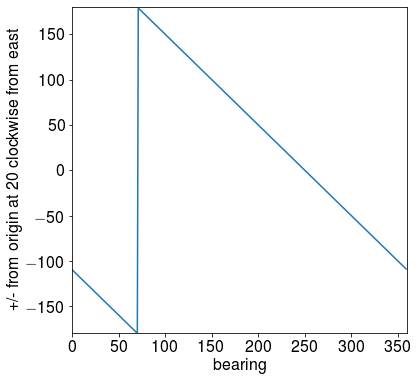

In [12]:
# this function returns directions of wind vectors af, as +-180 from af0
def bearing_2_pm180_af0(ai,af0):
    # ai is the bearing of the wind
    # af0 is the direction of the wind vector you wish to set as the origin
    af = np.copy(ai)
    af = -af - af0 - 90
    af[af<-180] = af[af<-180] + 360
    return af

t0 = 20
t1 = range(360)
t2 = bearing_2_pm180_af0(t1,t0)
fig = plt.gcf()
plt.plot(t1,t2)
plt.xlim(0,360)
plt.ylim(-180,180)
plt.xlabel('bearing',fontsize=fs*2)
plt.ylabel('+/- from origin at %d clockwise from east'%t0,fontsize=fs*2)
plt.xticks(fontsize=fs*2)
plt.yticks(fontsize=fs*2)
fig.set_size_inches(6, 6, forward=True)

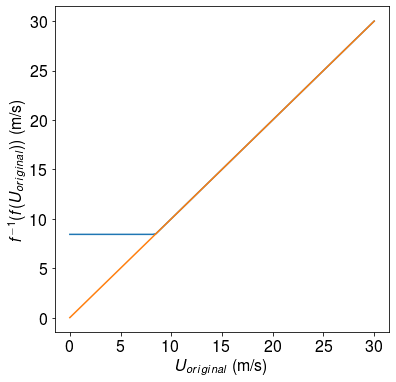

In [372]:
# gives you the volume flux scalar given wind speeds and grain diameter (not summed over time)
def flux(U,zU,z0):
    usabs = U*kap/np.log(zU/z0) # neutral law of the wall
    usabs[usabs<uscr] = uscr # get rid of negative unreal data
    constant = 2.8669917319 # this is the average value from Li et al (2010) and Ho et al (2011) as reported in Kok review, figure 2.15
    return constant*rhof/rhos/grav*uscr*usabs**2*(1-(uscr/usabs)**2) # this is Q_DK in Table 2.1 of Kok review

# does the inverse of the function above
def ufromflux(q,zU,z0): 
    constant = 2.8669917319
    return (q/uscr/constant/rhof*rhos*grav+uscr**2)**(1/2)/kap*np.log(zU/z0)

u1 = np.linspace(0,30,100)
u2 = ufromflux(flux(u1,zU,z00),zU,z00)
fig = plt.gcf()
plt.plot(u1,u2)
plt.plot([0,30],[0,30])
plt.xlabel('$U_{original}$ (m/s)',fontsize=fs*2)
plt.ylabel('$f^{-1}(f(U_{original}))$ (m/s)',fontsize=fs*2)
plt.xticks(fontsize=fs*2)
plt.yticks(fontsize=fs*2)
fig.set_size_inches(6, 6, forward=True)

## Theory

In [14]:
# this is the turbulence closure model
# it is a damping coefficient proportional to the forcing and mixing as a function of height
def a(Ag,z,z0,Z,L0):
    # Ag is the geostrophic flow speed
    # L0 is the eddy mixing length scale
    # z0 is the roughness length scale
    # Z is the ABL flow height
    return Ag*L0*np.log(z/z0)**-1*Z**-2

In [15]:
# functions to find a geostrophic flow for a given speed-elevation pair
# for the closure model a

def findg(g,u,z,z0):
    return np.abs(g/(1-1j*a(g,z,z0,Z,L0)/f))-u

def gfromu(u,z,z0):
    return root(findg,1,args=(u,z,z0),method='lm').x[0]

# Data

## DEM

To create the DEMs, made as .tif files, I used apdal functions via terminal. These are the steps to create them:
1. Download the the 3 point clouds from OpenTopography as .las files
2. These are in [x,y] convention, to create [x_r,y_r] versions run the command 
    `pdal translate -i andle-ws-MMMYY.las -o andle-ws-MMMYY-rotated.las -f transformation --filters.transformation.matrix="0.923879563808 0.382683426142 0 0 -0.382683426142 0.923879563808 0 0 0 0 1 0 0 0 0 1"` where MMMYY is like 'jun10' and the 4x4 matrix values are explained in 335deg_rotation_4matrix.txt
3. Now to create DEMs from each pair of .las files, run the commands `pdal pipeline dtm-common-grid.json` and `pdal pipeline dtm-rotated-common-grid.json` to generate the .tif files

The .json files have a `"bounds"` parameter which is set by the bounds of the union of the 3 .las files, meaning that all .tifs will have common grids.

In [51]:
# file locations

jan09 = 'DEMs/dem-zmin-andle-ws-jan09-common-grid.tif'
sep09 = 'DEMs/dem-zmin-andle-ws-sep09-common-grid.tif'
jun10 = 'DEMs/dem-zmin-andle-ws-jun10-common-grid.tif'

jan09r= 'DEMs/dem-zmin-andle-ws-jan09-rotated335-common-grid.tif' # r stands for rotated
sep09r= 'DEMs/dem-zmin-andle-ws-sep09-rotated335-common-grid.tif'
jun10r= 'DEMs/dem-zmin-andle-ws-jun10-rotated335-common-grid.tif'

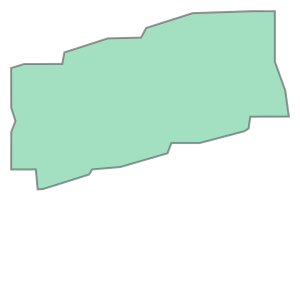

In [52]:
#parse the kmz
kmz = ZipFile('google-earth-files/jan09_lidar.kmz', 'r')
kml = kmz.open('doc.kml', 'r')
parser = xml.sax.make_parser()
handler = PlacemarkHandler()
parser.setContentHandler(handler)
parser.parse(kml)
kmz.close()

# find coordinate list in parsed kmz
coords = handler.mapping[list(handler.mapping)[0]]["coordinates"]
my_list = coords.split(",")

#restructure string into a useful array
verts = my_list[:-1]
vertsclean = np.empty([int(np.shape(verts)[0]/2),2])
polystart = [] #finds indices where new polys start and end

for j in np.arange(0,np.shape(verts)[0]):
    if '           ' in verts[j]:
        polystart.append(int(j/2))
    verts[j]=verts[j].replace('           ','')
    verts[j]=verts[j].replace('0 ','')
    verts[j]=verts[j].replace('0-','-')
    if j%2==0:
        vertsclean[int(j/2),0] = verts[j]
    else:
        vertsclean[int(j/2),1] = verts[j]
vertups_o = np.asarray(vertsclean)

jan09Vertups_o = np.empty_like(vertups_o)

p_lonlat = Proj(init='epsg:4326', preserve_units=False)
p_lidar = Proj(init='epsg:26913', preserve_units=False)

jan09Vertups_o[:,0], jan09Vertups_o[:,1] = transform(p_lonlat, p_lidar, vertups_o[:,0], vertups_o[:,1])

jan09_domain_o = Polygon(jan09Vertups_o)

jan09_domain_o

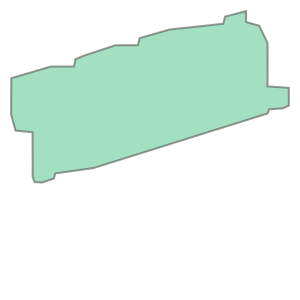

In [53]:
#parse the kmz
kmz = ZipFile('google-earth-files/sep09_lidar.kmz', 'r')
kml = kmz.open('doc.kml', 'r')
parser = xml.sax.make_parser()
handler = PlacemarkHandler()
parser.setContentHandler(handler)
parser.parse(kml)
kmz.close()

# find coordinate list in parsed kmz
coords = handler.mapping[list(handler.mapping)[0]]["coordinates"]
my_list = coords.split(",")

#restructure string into a useful array
verts = my_list[:-1]
vertsclean = np.empty([int(np.shape(verts)[0]/2),2])
polystart = [] #finds indices where new polys start and end

for j in np.arange(0,np.shape(verts)[0]):
    if '           ' in verts[j]:
        polystart.append(int(j/2))
    verts[j]=verts[j].replace('           ','')
    verts[j]=verts[j].replace('0 ','')
    verts[j]=verts[j].replace('0-','-')
    if j%2==0:
        vertsclean[int(j/2),0] = verts[j]
    else:
        vertsclean[int(j/2),1] = verts[j]
vertups_o = np.asarray(vertsclean)

sep09Vertups_o = np.empty_like(vertups_o)

p_lonlat = Proj(init='epsg:4326', preserve_units=False)
p_lidar = Proj(init='epsg:26913', preserve_units=False)

sep09Vertups_o[:,0], sep09Vertups_o[:,1] = transform(p_lonlat, p_lidar, vertups_o[:,0], vertups_o[:,1])

sep09_domain_o = Polygon(sep09Vertups_o)

sep09_domain_o

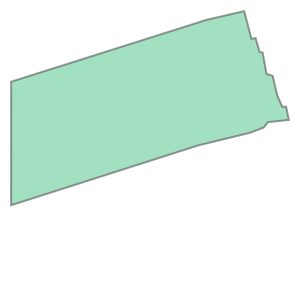

In [54]:
#parse the kmz
kmz = ZipFile('google-earth-files/jun10_lidar.kmz', 'r')
kml = kmz.open('doc.kml', 'r')
parser = xml.sax.make_parser()
handler = PlacemarkHandler()
parser.setContentHandler(handler)
parser.parse(kml)
kmz.close()

# find coordinate list in parsed kmz
coords = handler.mapping[list(handler.mapping)[0]]["coordinates"]
my_list = coords.split(",")

#restructure string into a useful array
verts = my_list[:-1]
vertsclean = np.empty([int(np.shape(verts)[0]/2),2])
polystart = [] #finds indices where new polys start and end

for j in np.arange(0,np.shape(verts)[0]):
    if '           ' in verts[j]:
        polystart.append(int(j/2))
    verts[j]=verts[j].replace('           ','')
    verts[j]=verts[j].replace('0 ','')
    verts[j]=verts[j].replace('0-','-')
    if j%2==0:
        vertsclean[int(j/2),0] = verts[j]
    else:
        vertsclean[int(j/2),1] = verts[j]
vertups_o = np.asarray(vertsclean)

jun10Vertups_o = np.empty_like(vertups_o)

p_lonlat = Proj(init='epsg:4326', preserve_units=False)
p_lidar = Proj(init='epsg:26913', preserve_units=False)

jun10Vertups_o[:,0], jun10Vertups_o[:,1] = transform(p_lonlat, p_lidar, vertups_o[:,0], vertups_o[:,1])

jun10_domain_o = Polygon(jun10Vertups_o)

jun10_domain_o

In [55]:
# grab dems x y and z arrays

ds = gdal.Open(sep09, gdal.GA_ReadOnly)
rb = ds.GetRasterBand(1)
metaxy = ds.GetGeoTransform()
z_sep09 = np.flip(rb.ReadAsArray(),axis=0)
x = metaxy[0]+metaxy[1]*np.arange(0,np.shape(z_sep09)[1])
y = np.flip(metaxy[3]+metaxy[5]*np.arange(0,np.shape(z_sep09)[0]))
X,Y = np.meshgrid(x,y)

In [56]:
ds = gdal.Open(jun10r, gdal.GA_ReadOnly)
rb = ds.GetRasterBand(1)
metaxy = ds.GetGeoTransform()
zr_jun10 = np.flip(rb.ReadAsArray(),axis=0)
zr_jun10[zr_jun10<0] = np.nan
xr = metaxy[0]+metaxy[1]*np.arange(0,np.shape(zr_jun10)[1])
yr = np.flip(metaxy[3]+metaxy[5]*np.arange(0,np.shape(zr_jun10)[0]))

In [57]:
ds = gdal.Open(jan09r, gdal.GA_ReadOnly)
rb = ds.GetRasterBand(1)
metaxy = ds.GetGeoTransform()
zr_jan09 = np.flip(rb.ReadAsArray(),axis=0)
zr_jan09[zr_jan09<0] = np.nan

ds = gdal.Open(sep09r, gdal.GA_ReadOnly)
rb = ds.GetRasterBand(1)
zr_sep09 = np.flip(rb.ReadAsArray(),axis=0)
zr_sep09[zr_sep09<0] = np.nan

dems = [zr_jan09,zr_sep09,zr_jun10]
del zr_jan09, zr_sep09

## In-situ

### Spatial

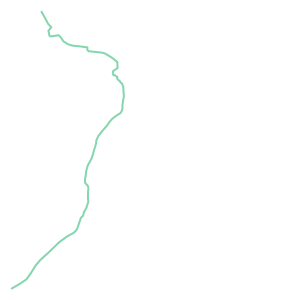

In [409]:
#parse the kmz
kmz = ZipFile('google-earth-files/upwind_margin.kmz', 'r')
kml = kmz.open('doc.kml', 'r')
parser = xml.sax.make_parser()
handler = PlacemarkHandler()
parser.setContentHandler(handler)
parser.parse(kml)
kmz.close()

# find coordinate list in parsed kmz
coords = handler.mapping[list(handler.mapping)[0]]["coordinates"]
my_list = coords.split(",")

#restructure string into a useful array
verts = my_list[:-1]
vertsclean = np.empty([int(np.shape(verts)[0]/2),2])
polystart = [] #finds indices where new polys start and end

for j in np.arange(0,np.shape(verts)[0]):
    if '           ' in verts[j]:
        polystart.append(int(j/2))
    verts[j]=verts[j].replace('           ','')
    verts[j]=verts[j].replace('0 ','')
    verts[j]=verts[j].replace('0-','-')
    if j%2==0:
        vertsclean[int(j/2),0] = verts[j]
    else:
        vertsclean[int(j/2),1] = verts[j]
vertups_o = np.asarray(vertsclean)

upwindVertups_o = np.empty_like(vertups_o)

p_lonlat = Proj(init='epsg:4326', preserve_units=False)
p_lidar = Proj(init='epsg:26913', preserve_units=False)

upwindVertups_o[:,0], upwindVertups_o[:,1] = transform(p_lonlat, p_lidar, vertups_o[:,0], vertups_o[:,1])

upwind_boundary_o = LineString(upwindVertups_o)

upwind_boundary_o

In [408]:
# rotate the polygon above to match the rotated dems
upwindVertups_r = np.empty_like(upwindVertups_o)
upwindVertups_r[:,0] =  upwindVertups_o[:,0]*np.cos(af0_r)+upwindVertups_o[:,1]*np.sin(af0_r)
upwindVertups_r[:,1] = -upwindVertups_o[:,0]*np.sin(af0_r)+upwindVertups_o[:,1]*np.cos(af0_r)
upwind_boundary_r = LineString(upwindVertups_r)

In [407]:
#met tower locations in this coordinate system

x_a_o, y_a_o = transform(p_lonlat, p_lidar, -106.289875, 32.863286)
tempx2 = np.max(upwindVertups_o[:,0])
tempy2 = y_a_o + (tempx2-x_a_o)*np.tan(af0*np.pi/180)
tempp3 = LineString([(x_a_o,y_a_o),(tempx2,tempy2)]).intersection(upwind_boundary_o)
s_a_o  = -LineString([(tempp3.coords[0][0],tempp3.coords[0][1]),(x_a_o, y_a_o)]).length

x_b_o, y_b_o = transform(p_lonlat, p_lidar, -106.252210, 32.875672)
tempx2 = np.min(upwindVertups_o[:,0])
tempy2 = y_b_o - (x_b_o-tempx2)*np.tan(af0*np.pi/180)
tempp3 = LineString([(x_b_o,y_b_o),(tempx2,tempy2)]).intersection(upwind_boundary_o)
s_b_o = LineString([(tempp3.coords[0][0],tempp3.coords[0][1]),(x_b_o, y_b_o)]).length

x_c_o, y_c_o = transform(p_lonlat, p_lidar, -106.230702, 32.885072)
tempx2 = np.min(upwindVertups_o[:,0])
tempy2 = y_c_o - (x_c_o-tempx2)*np.tan(af0*np.pi/180)
tempp3 = LineString([(x_c_o,y_c_o),(tempx2,tempy2)]).intersection(upwind_boundary_o)
s_c_o = LineString([(tempp3.coords[0][0],tempp3.coords[0][1]),(x_c_o, y_c_o)]).length

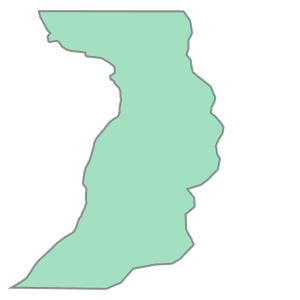

In [43]:
#parse the kmz
kmz = ZipFile('google-earth-files/ws_duneboundary.kmz', 'r')
kml = kmz.open('doc.kml', 'r')
parser = xml.sax.make_parser()
handler = PlacemarkHandler()
parser.setContentHandler(handler)
parser.parse(kml)
kmz.close()

# find coordinate list in parsed kmz
coords = handler.mapping[list(handler.mapping)[0]]["coordinates"]
my_list = coords.split(",")

#restructure string into a useful array
verts = my_list[:-1]
vertsclean = np.empty([int(np.shape(verts)[0]/2),2])
polystart = [] #finds indices where new polys start and end

for j in np.arange(0,np.shape(verts)[0]):
    if '           ' in verts[j]:
        polystart.append(int(j/2))
    verts[j]=verts[j].replace('           ','')
    verts[j]=verts[j].replace('0 ','')
    verts[j]=verts[j].replace('0-','-')
    if j%2==0:
        vertsclean[int(j/2),0] = verts[j]
    else:
        vertsclean[int(j/2),1] = verts[j]
vertups_o = np.asarray(vertsclean)

dfVertups_o = np.empty_like(vertups_o)

p_lonlat = Proj(init='epsg:4326', preserve_units=False)
p_lidar = Proj(init='epsg:26913', preserve_units=False)

dfVertups_o[:,0], dfVertups_o[:,1] = transform(p_lonlat, p_lidar, vertups_o[:,0], vertups_o[:,1])

df_domain_o = Polygon(dfVertups_o)
df_domain_o

In [44]:
# get the length of the dune field in the direction of the dunes on a transect that passes through met a

x_a_o, y_a_o = transform(p_lonlat, p_lidar, -106.289875, 32.863286)
tempx2 = np.max(dfVertups_o[:,0])
tempy2 = y_a_o + (tempx2-x_a_o)*np.tan(af0*np.pi/180)
tempp3 = LineString([(x_a_o,y_a_o),(tempx2,tempy2)]).intersection(df_domain_o)
s_r_m = LineString([(tempp3.coords[0][0],tempp3.coords[0][1]),(tempp3.coords[1][0],tempp3.coords[1][1])]).length

In [45]:
s_r_m

4990.752334535894

### Met towers

In [17]:
# file locations of the met tower data
pa0 = 'mets/Tower1/Tower1_7-17-15/Tower1_Avg10Min.dat'
pa1 = 'mets/Tower1/Tower1_8-15-15/Tower1_Avg10Min_2015_08_15_08_15_22.dat'
pa2 = 'mets/Tower1/Tower1_8-3-15/Tower1_Avg10Min_2015_08_03_12_20_02.dat'

pb0 = 'mets/Tower2/Tower2_7-17-15/Tower2_Avg10Min.dat'
pb1 = 'mets/Tower2/Tower2_8-15-15/Tower2_Avg10Min_2015_08_15_09_17_56.dat'
pb2 = 'mets/Tower2/Tower2_8-3-15/Tower2_Avg10Min_2015_08_03_12_34_29.dat'

pc0 = 'mets/Tower3/Tower3_7-17-15/Tower3_Avg10Min.dat'
pc1 = 'mets/Tower3/Tower3_7-6-15/Tower3_Avg10Min.dat'
pc2 = 'mets/Tower3/Tower3_8-15-15/Tower3_Avg10Min_2015_08_15_09_32_09.dat'

# 2nd file for tower1 is weird, omit
path = [pa0,pa1,pb0,pb1,pb2,pc0,pc1,pc2]
towe = ['a','a','b','b','b','c','c','c'] # towers are lettered in order of downwind

ta = [] # time: tower
tb = []
tc = []

aai = [] # angle: tower, initial
abi = []
aci = []

u0a = [] # speed: numbered height, tower
u1a = []
u2a = []
u0b = []
u1b = []
u2b = []
u0c = []
u1c = []
u2c = []

# grab data
for i in range(0,np.shape(path)[0]):
    tempdata = pd.read_csv(path[i],header=1)
    if towe[i]=='a':
        ta  = np.append(ta,tempdata.iloc[2:,0])
        aai = np.append(aai,tempdata.iloc[2:,3])
        u0a = np.append(u0a,tempdata.iloc[2:,12])
        u1a = np.append(u1a,tempdata.iloc[2:,8])
        u2a = np.append(u2a,tempdata.iloc[2:,2])
    elif towe[i]=='b':
        tb  = np.append(tb,tempdata.iloc[2:,0])
        abi = np.append(abi,tempdata.iloc[2:,3])
        u0b = np.append(u0b,tempdata.iloc[2:,12])
        u1b = np.append(u1b,tempdata.iloc[2:,8])
        u2b = np.append(u2b,tempdata.iloc[2:,2])     
    elif towe[i]=='c':
        tc  = np.append(tc,tempdata.iloc[2:,0])
        aci = np.append(aci,tempdata.iloc[2:,3])
        u0c = np.append(u0c,tempdata.iloc[2:,12])
        u1c = np.append(u1c,tempdata.iloc[2:,8])
        u2c = np.append(u2c,tempdata.iloc[2:,2])
        
tas = [] # time: tower, seconds
tbs = []
tcs = []

# put times in seconds
for i in ta:
    try:
        tas.append(int(time.mktime(datetime.datetime.strptime(i,'%Y-%m-%d %H:%M:%S').timetuple())))
    except:
        #because it does 24:00:00 and datetime doesn't like that
        tas.append(int(time.mktime(datetime.datetime.strptime(i[:-9],'%Y-%m-%d').timetuple()))+24*60*60)

for i in tb:
    try:
        tbs.append(int(time.mktime(datetime.datetime.strptime(i,'%Y-%m-%d %H:%M:%S').timetuple())))
    except:
        #because it does 24:00:00 and datetime doesn't like that
        tbs.append(int(time.mktime(datetime.datetime.strptime(i[:-9],'%Y-%m-%d').timetuple()))+24*60*60)
        
for i in tc:
    try:
        tcs.append(int(time.mktime(datetime.datetime.strptime(i,'%Y-%m-%d %H:%M:%S').timetuple())))
    except:
        #because it does 24:00:00 and datetime doesn't like that
        tcs.append(int(time.mktime(datetime.datetime.strptime(i[:-9],'%Y-%m-%d').timetuple()))+24*60*60)
        
tas = np.asarray(tas)
tbs = np.asarray(tbs)
tcs = np.asarray(tcs)

# unfortunately met a was installed such that it thinks true north is 7 degrees counterclockwise of reality
FIXMETaANGLE = 7
aai = np.asarray(aai,dtype=np.float)+FIXMETaANGLE # correct this issue
abi = np.asarray(abi,dtype=np.float)
aci = np.asarray(aci,dtype=np.float)

# change the directions such that they are all +-180 of dune orientation
# instead of +360 clockwise of north
aa  = bearing_2_pm180_af0(aai,af0) # angle: tower (convention changed)
ab  = bearing_2_pm180_af0(abi,af0)
ac  = bearing_2_pm180_af0(aci,af0)

u0a = np.asarray(u0a,dtype=np.float)
u1a = np.asarray(u1a,dtype=np.float)
u2a = np.asarray(u2a,dtype=np.float)
u0b = np.asarray(u0b,dtype=np.float)
u1b = np.asarray(u1b,dtype=np.float)
u2b = np.asarray(u2b,dtype=np.float)
u0c = np.asarray(u0c,dtype=np.float)
u1c = np.asarray(u1c,dtype=np.float)
u2c = np.asarray(u2c,dtype=np.float)

z_m = np.asarray([2,5,10]) # heights of speeds, meters
dts_m = tas[1]-tas[0] # time in seconds between wind speed measurements

/home/andrew/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (1,2,3,4,5,6,8,9,10,12,13,14,16,17,18,19,20,21,22,23,24,25,26,27) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [18]:
# function that takes all of the mutual times for the met towers
# and creates a list of unique common values
tsc = reduce(np.intersect1d, (tas, tbs, tcs)) # time: seconds, common

aac = [] # angle: tower, common
abc = []
acc = []

u0ac = [] # speed: numbered height, tower, common
u1ac = []
u2ac = []
u0bc = []
u1bc = []
u2bc = []
u0cc = []
u1cc = []
u2cc = []

for i in range(0,np.shape(tsc)[0]):
    aac = np.append(aac,aa[tas==tsc[i]][0])
    abc = np.append(abc,ab[tbs==tsc[i]][0])
    acc = np.append(acc,ac[tcs==tsc[i]][0])
    
    u0ac = np.append(u0ac,u0a[tas==tsc[i]][0])
    u1ac = np.append(u1ac,u1a[tas==tsc[i]][0])
    u2ac = np.append(u2ac,u2a[tas==tsc[i]][0])
    u0bc = np.append(u0bc,u0b[tbs==tsc[i]][0])
    u1bc = np.append(u1bc,u1b[tbs==tsc[i]][0])
    u2bc = np.append(u2bc,u2b[tbs==tsc[i]][0])
    u0cc = np.append(u0cc,u0c[tcs==tsc[i]][0])
    u1cc = np.append(u1cc,u1c[tcs==tsc[i]][0])
    u2cc = np.append(u2cc,u2c[tcs==tsc[i]][0])

### Lidar

In [19]:
############
## LIDAR 2017 ##
############

# to read files
months = range(1,12+1)
days   = range(1,31+1)
part   = range(1,3)

z_l1 = np.asarray([10,13,16,22,28,36,38,46,60,77,300])

t_l1 = [] # icol 2  timestamp [s]
d_l1 = [] # icol 1 DD/MM/YYYY HH:MM:SS

gps_l1 = []
 
u1_l1 = [] # speed: numbered height, lidar unit number
u2_l1 = []
u3_l1 = []
u4_l1 = []
u5_l1 = []
u6_l1 = []
u7_l1 = []
u8_l1 = []
u9_l1 = []
u10_l1 = []
u11_l1 = []

a1_l1i = [] # angle: numbered height, lidar unit number, initial convention

# grab data
for i in months:
    for j in days:
        temp_path = Path('lidar/lidar17_csvs/Wind_320@Y2017_M%02d_D%02d.CSV' % (i,j))
        if temp_path.is_file():
            tempdata = pd.read_csv(temp_path,delimiter=',',header=1)
            
            t_l1.extend(tempdata.iloc[:,2])
            d_l1.extend(pd.to_datetime(tempdata.iloc[:,1]) - pd.Timedelta(hours=2)) # correct timezone from indiana to alamogordo
            
            gps_l1.extend(tempdata.iloc[:,10])
            
            u11_l1.extend(tempdata.iloc[:,20])
            u10_l1.extend(tempdata.iloc[:,23])
            u9_l1.extend(tempdata.iloc[:,26])
            u8_l1.extend(tempdata.iloc[:,29])
            u7_l1.extend(tempdata.iloc[:,32])
            u6_l1.extend(tempdata.iloc[:,35])
            u5_l1.extend(tempdata.iloc[:,38])
            u4_l1.extend(tempdata.iloc[:,41])
            u3_l1.extend(tempdata.iloc[:,44])
            u2_l1.extend(tempdata.iloc[:,47])
            u1_l1.extend(tempdata.iloc[:,50])

            a1_l1i.extend(tempdata.iloc[:,49])

        for k in part:
            temp_path = Path('lidar/lidar17_csvs/Wind_320@Y2017_M%02d_D%02d-%d.CSV' % (i,j,k))
            if temp_path.is_file():
                tempdata = pd.read_csv(temp_path,delimiter=',',header=1)
                
                t_l1.extend(tempdata.iloc[:,2])
                d_l1.extend(pd.to_datetime(tempdata.iloc[:,1]) - pd.Timedelta(hours=2)) #correct timezone from indiana to alamogordo
            
                gps_l1.extend(tempdata.iloc[:,10])

                u11_l1.extend(tempdata.iloc[:,20])
                u10_l1.extend(tempdata.iloc[:,23])
                u9_l1.extend(tempdata.iloc[:,26])
                u8_l1.extend(tempdata.iloc[:,29])
                u7_l1.extend(tempdata.iloc[:,32])
                u6_l1.extend(tempdata.iloc[:,35])
                u5_l1.extend(tempdata.iloc[:,38])
                u4_l1.extend(tempdata.iloc[:,41])
                u3_l1.extend(tempdata.iloc[:,44])
                u2_l1.extend(tempdata.iloc[:,47])
                u1_l1.extend(tempdata.iloc[:,50])

                a1_l1i.extend(tempdata.iloc[:,49])

t_l1 = np.asarray(t_l1)

gps_l1 = np.asarray(gps_l1)

u1_l1 = np.asarray(u1_l1)
u2_l1 = np.asarray(u2_l1)
u3_l1 = np.asarray(u3_l1)
u4_l1 = np.asarray(u4_l1)
u5_l1 = np.asarray(u5_l1)
u6_l1 = np.asarray(u6_l1)
u7_l1 = np.asarray(u7_l1)
u8_l1 = np.asarray(u8_l1)
u9_l1 = np.asarray(u9_l1)
u10_l1 = np.asarray(u10_l1)
u11_l1 = np.asarray(u11_l1)

a1_l1i = np.asarray(a1_l1i)

#####

# remove bad data
bad_index = np.append(np.argwhere(u1_l1==9999.0),np.argwhere(gps_l1=='#N/A #N/A'))

bad_index = np.append(bad_index,np.argwhere(u2_l1==9999.0))
bad_index = np.append(bad_index,np.argwhere(u3_l1==9999.0))
bad_index = np.append(bad_index,np.argwhere(u4_l1==9999.0))
bad_index = np.append(bad_index,np.argwhere(u5_l1==9999.0))
bad_index = np.append(bad_index,np.argwhere(u6_l1==9999.0))
bad_index = np.append(bad_index,np.argwhere(u7_l1==9999.0))
bad_index = np.append(bad_index,np.argwhere(u8_l1==9999.0))
bad_index = np.append(bad_index,np.argwhere(u9_l1==9999.0))
bad_index = np.append(bad_index,np.argwhere(u10_l1==9999.0))
bad_index = np.append(bad_index,np.argwhere(u11_l1==9999.0))

bad_index = np.append(bad_index,np.argwhere(np.isnan(u1_l1)))
bad_index = np.append(bad_index,np.argwhere(np.isnan(u2_l1)))
bad_index = np.append(bad_index,np.argwhere(np.isnan(u3_l1)))
bad_index = np.append(bad_index,np.argwhere(np.isnan(u4_l1)))
bad_index = np.append(bad_index,np.argwhere(np.isnan(u5_l1)))
bad_index = np.append(bad_index,np.argwhere(np.isnan(u6_l1)))
bad_index = np.append(bad_index,np.argwhere(np.isnan(u7_l1)))
bad_index = np.append(bad_index,np.argwhere(np.isnan(u8_l1)))
bad_index = np.append(bad_index,np.argwhere(np.isnan(u9_l1)))
bad_index = np.append(bad_index,np.argwhere(np.isnan(u10_l1)))
bad_index = np.append(bad_index,np.argwhere(np.isnan(u11_l1)))

t_l1 = np.delete(t_l1,bad_index)
d_l1 = np.delete(d_l1,bad_index)

u1_l1 = np.delete(u1_l1,bad_index)
u2_l1 = np.delete(u2_l1,bad_index)
u3_l1 = np.delete(u3_l1,bad_index)
u4_l1 = np.delete(u4_l1,bad_index)
u5_l1 = np.delete(u5_l1,bad_index)
u6_l1 = np.delete(u6_l1,bad_index)
u7_l1 = np.delete(u7_l1,bad_index)
u8_l1 = np.delete(u8_l1,bad_index)
u9_l1 = np.delete(u9_l1,bad_index)
u10_l1 = np.delete(u10_l1,bad_index)
u11_l1 = np.delete(u11_l1,bad_index)

u_l1 = np.asarray([u1_l1,u2_l1,u3_l1,u4_l1,u5_l1,u6_l1,u7_l1,u8_l1,u9_l1,u10_l1,u11_l1])

a1_l1i = np.delete(a1_l1i,bad_index)
a1_l1  = bearing_2_pm180_af0(a1_l1i,af0) #angle in analyzed convention

In [20]:
print('total number of days of observations for lidar 1 is %d'%(len(t_l1)*17/60/60/24))

total number of days of observations for lidar 1 is 58


In [21]:
############
## LIDAR 2018 ##
############
# as above but for location b the next year

# to read files
months = range(1,12+1)
days   = range(1,31+1)
part   = range(1,3)

z_l2 = np.asarray([10,14,20,28,38,55,78,300])

t_l2 = [] # icol 2  timestamp [s]
d_l2 = [] #icol 1 DD/MM/YYYY HH:MM:SS

gps_l2 = []

u1_l2 = []
u2_l2 = []
u3_l2 = []
u4_l2 = []
u5_l2 = []
u6_l2 = []
u7_l2 = []
u11_l2 = []

a1_l2i = []

for i in months:
    for j in days:
        temp_path = Path('lidar/lidar18_csvs/Wind_320@Y2018_M%02d_D%02d.CSV' % (i,j))
        if temp_path.is_file():
            tempdata = pd.read_csv(temp_path,delimiter=',',header=1)
            
            t_l2.extend(tempdata.iloc[:,2])
            d_l2.extend(pd.to_datetime(tempdata.iloc[:,1]) - pd.Timedelta(hours=2)) #correct timezone from indiana to alamogordo
            
            gps_l2.extend(tempdata.iloc[:,10])
            
            u11_l2.extend(tempdata.iloc[:,20])
            u7_l2.extend(tempdata.iloc[:,32])
            u6_l2.extend(tempdata.iloc[:,35])
            u5_l2.extend(tempdata.iloc[:,38])
            u4_l2.extend(tempdata.iloc[:,41])
            u3_l2.extend(tempdata.iloc[:,44])
            u2_l2.extend(tempdata.iloc[:,47])
            u1_l2.extend(tempdata.iloc[:,50])
            
            a1_l2i.extend(tempdata.iloc[:,49])
            
        for k in part:
            temp_path = Path('lidar/lidar18_csvs/Wind_320@Y2018_M%02d_D%02d-%d.CSV' % (i,j,k))
            if temp_path.is_file():
                tempdata = pd.read_csv(temp_path,delimiter=',',header=1)
                
                t_l2.extend(tempdata.iloc[:,2])
                d_l2.extend(pd.to_datetime(tempdata.iloc[:,1]) - pd.Timedelta(hours=2)) #correct timezone from indiana to alamogordo
            
                gps_l2.extend(tempdata.iloc[:,10])

                u11_l2.extend(tempdata.iloc[:,20])
                u7_l2.extend(tempdata.iloc[:,32])
                u6_l2.extend(tempdata.iloc[:,35])
                u5_l2.extend(tempdata.iloc[:,38])
                u4_l2.extend(tempdata.iloc[:,41])
                u3_l2.extend(tempdata.iloc[:,44])
                u2_l2.extend(tempdata.iloc[:,47])
                u1_l2.extend(tempdata.iloc[:,50])

                a1_l2i.extend(tempdata.iloc[:,49])


t_l2 = np.asarray(t_l2)

gps_l2 = np.asarray(gps_l2)

u1_l2 = np.asarray(u1_l2)
u2_l2 = np.asarray(u2_l2)
u3_l2 = np.asarray(u3_l2)
u4_l2 = np.asarray(u4_l2)
u5_l2 = np.asarray(u5_l2)
u6_l2 = np.asarray(u6_l2)
u7_l2 = np.asarray(u7_l2)
u11_l2 = np.asarray(u11_l2)

a1_l2i = np.asarray(a1_l2i)

#####

bad_index = np.append(np.argwhere(u1_l2==9999.0),np.argwhere(gps_l2=='#N/A #N/A'))

bad_index = np.append(bad_index,np.argwhere(u2_l2==9999.0))
bad_index = np.append(bad_index,np.argwhere(u3_l2==9999.0))
bad_index = np.append(bad_index,np.argwhere(u4_l2==9999.0))
bad_index = np.append(bad_index,np.argwhere(u5_l2==9999.0))
bad_index = np.append(bad_index,np.argwhere(u6_l2==9999.0))
bad_index = np.append(bad_index,np.argwhere(u7_l2==9999.0))
bad_index = np.append(bad_index,np.argwhere(u11_l2==9999.0))

bad_index = np.append(bad_index,np.argwhere(np.isnan(u1_l2)))
bad_index = np.append(bad_index,np.argwhere(np.isnan(u2_l2)))
bad_index = np.append(bad_index,np.argwhere(np.isnan(u3_l2)))
bad_index = np.append(bad_index,np.argwhere(np.isnan(u4_l2)))
bad_index = np.append(bad_index,np.argwhere(np.isnan(u5_l2)))
bad_index = np.append(bad_index,np.argwhere(np.isnan(u6_l2)))
bad_index = np.append(bad_index,np.argwhere(np.isnan(u7_l2)))
bad_index = np.append(bad_index,np.argwhere(np.isnan(u11_l2)))

t_l2 = np.delete(t_l2,bad_index)
d_l2 = np.delete(d_l2,bad_index)

u1_l2 = np.delete(u1_l2,bad_index)
u2_l2 = np.delete(u2_l2,bad_index)
u3_l2 = np.delete(u3_l2,bad_index)
u4_l2 = np.delete(u4_l2,bad_index)
u5_l2 = np.delete(u5_l2,bad_index)
u6_l2 = np.delete(u6_l2,bad_index)
u7_l2 = np.delete(u7_l2,bad_index)
u11_l2 = np.delete(u11_l2,bad_index)

u_l2 = np.asarray([u1_l2,u2_l2,u3_l2,u4_l2,u5_l2,u6_l2,u7_l2,u11_l2])

a1_l2i = np.delete(a1_l2i,bad_index)
a1_l2  = bearing_2_pm180_af0(a1_l2i,af0)

In [22]:
print('total number of days of observations for lidar 2 is %d'%(len(t_l2)*17/60/60/24))

total number of days of observations for lidar 2 is 18


# Analysis

## DEM

In [34]:
# measure topography variability (similar to roughness)
# done on zr_jun10, almost identical for each dem

temp = np.copy(zr_jun10)
temp[np.isnan(temp)] = 0 # to allow function below
stdr_jun10 = window_std(temp,stdwidth) # make a map of local (100m^2 tile) standard deviation
del temp
stdr_jun10[stdr_jun10>10] = np.nan # remove spuriously large values
stdr_jun10[np.isnan(zr_jun10)] = np.nan # remove values outside of map

stdr_jun10s = np.empty([np.shape(yr)[0],np.shape(xr)[0]+uwimax])
stdr_jun10s[:] = np.nan # map: stdr: standard deviation, r: rotated, jun10: month observed, s: x_r normed to distance from boundary

# shifts each transect in xr such that they all pass through the upwind boundary at a common array index
# this means that for a common index you're equidistant from the boundary
# this frame of reference is called sr, and is useful for span-wise averages
for i in np.arange(np.shape(yr)[0]):
    templ = LineString([(np.min(xr),yr[i]),(np.max(xr),yr[i])])
    tempp = templ.intersection(upwind_boundary_r)
    try:
        uwi = np.argmin(np.abs(xr-tempp.coords[0][0]))
        stdr_jun10s[i,uwimax-uwi:np.shape(xr)[0]+uwimax-uwi] = stdr_jun10[i,:]
    except:
        continue

del stdr_jun10
with open('DEMs/stdr_jun10s.pkl', 'wb') as file:
    pickle.dump(stdr_jun10s, file)
del stdr_jun10s

/home/andrew/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in sqrt
  
/home/andrew/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


In [33]:
# create a mean transect of topography variability
with open('DEMs/stdr_jun10s.pkl', 'rb') as file:
    stdr_jun10s = pickle.load(file)
stdr_jun10savg = np.nanmean(stdr_jun10s,axis=0) # span-wise average
sr = np.arange(np.shape(stdr_jun10s)[1])-uwimax # along transect distance (grid spacing is 1 m)
del stdr_jun10s

/home/andrew/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.


In [36]:
# unbias the dem differences and make sediment flux maps
dzdtcs = demcorrect(dems,dempairs,demdts)
for i in range(len(dempairs)):
    qs = demflux(dems[dempairs[i][1]],dems[dempairs[i][0]],dzdtcs[i],xr)
    with open('DEMs/qs%d.pkl'%i, 'wb') as file:
        pickle.dump(qs, file)
del dzdtcs, qs

/home/andrew/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()
/home/andrew/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in less


In [37]:
# change flux maps in xr,yr to sr,yr
for i in range(len(dempairs)):
    with open('DEMs/qs%d.pkl'%i, 'rb') as file:
        qs = pickle.load(file)
    
    qss = np.empty([np.shape(yr)[0],np.shape(xr)[0]+uwimax])
    qss[:] = np.nan
    for j in np.arange(np.shape(yr)[0]):
        templ = LineString([(np.min(xr),yr[j]),(np.max(xr),yr[j])])
        tempp = templ.intersection(upwind_boundary_r)
        try:
            uwi = np.argmin(np.abs(xr-tempp.coords[0][0]))
            qss[j,uwimax-uwi:np.shape(xr)[0]+uwimax-uwi-1] = qs[j,:]
        except:
            continue
    with open('DEMs/qs%ds.pkl'%i, 'wb') as file:
        pickle.dump(qss, file)
del qs, qss

In [68]:
# create mean transects of sediment flux and variability
qavg = []
qp25 = []
qp75 = []

for i in range(len(dempairs)):
    with open('DEMs/qs%ds.pkl'%i, 'rb') as file:
        qss = pickle.load(file)
    qavg.append(np.nanmean(qss,axis=0))
    qp25.append(np.nanpercentile(qss,25,axis=0))
    qp75.append(np.nanpercentile(qss,75,axis=0))
del qss

/home/andrew/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':
/home/andrew/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1392: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


In [433]:
# get the variability in dune direction from each map
ds = gdal.Open(jan09, gdal.GA_ReadOnly)
rb = ds.GetRasterBand(1)
z_jan09 = np.flip(rb.ReadAsArray(),axis=0)
ds = gdal.Open(jun10, gdal.GA_ReadOnly)
rb = ds.GetRasterBand(1)
z_jun10 = np.flip(rb.ReadAsArray(),axis=0)

pdd_jan09,ppd_bins = angledist(z_jan09,x,y,5,df_domain_o)
pdd_sep09,_ = angledist(z_sep09,x,y,5,df_domain_o)
pdd_jun10,_ = angledist(z_jun10,x,y,5,df_domain_o)

del z_jan09, z_jun10

/home/andrew/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less
  


## In-situ

In [373]:
# get aligned concurrent winds from the met towers
# winds within adelta (15 degrees) of the dune direction
# and within adelta of the upwind wind direction

# 2 m elevation
u0aca = u0ac[(aac<1*adelta)&(aac>-1*adelta)&
             (abc<2*adelta)&(abc>-2*adelta)&
             (acc<3*adelta)&(acc>-3*adelta)] # speed: numbered height, tower, common, aligned
u0bca = u0bc[(aac<1*adelta)&(aac>-1*adelta)&
             (abc<2*adelta)&(abc>-2*adelta)&
             (acc<3*adelta)&(acc>-3*adelta)]
u0cca = u0cc[(aac<1*adelta)&(aac>-1*adelta)&
             (abc<2*adelta)&(abc>-2*adelta)&
             (acc<3*adelta)&(acc>-3*adelta)]

# 10 m elevation
u2aca = u2ac[(aac<1*adelta)&(aac>-1*adelta)&
             (abc<2*adelta)&(abc>-2*adelta)&
             (acc<3*adelta)&(acc>-3*adelta)] # speed: numbered height, tower, common, aligned
u2bca = u2bc[(aac<1*adelta)&(aac>-1*adelta)&
             (abc<2*adelta)&(abc>-2*adelta)&
             (acc<3*adelta)&(acc>-3*adelta)]
u2cca = u2cc[(aac<1*adelta)&(aac>-1*adelta)&
             (abc<2*adelta)&(abc>-2*adelta)&
             (acc<3*adelta)&(acc>-3*adelta)]

# get fluxes from some of these winds
q2a = flux(u0a,z_m[2],z00) # assumed local roughness of z00
q2bca_av = np.mean(flux(u2bca,z_m[2],z00))
q2cca_av = np.mean(flux(u2cca,z_m[2],z00))

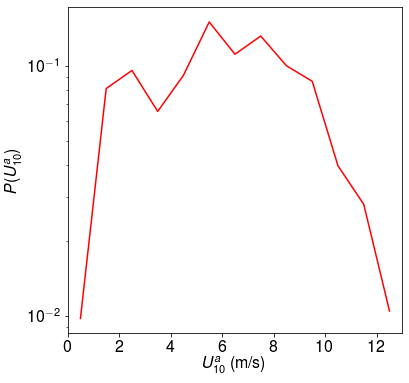

In [374]:
# get the probability distribution of aligned wind speeds
ubins = np.linspace(0,13,14)
ubinmids = ubins[1:] - np.diff(ubins)[0]/2

u2acnt,_ = np.histogram(u2aca,bins=ubins)

pu2a = u2acnt/np.sum(u2acnt)

fig = plt.gcf()
plt.subplot(111)
plt.plot(ubinmids,pu2a,color='r')
plt.yscale('log')

plt.xlim(0,13)

plt.ylabel('$P(U^a_{10})$',fontsize=fs*2)
plt.xlabel('$U^a_{10}$ (m/s)',fontsize=fs*2)

plt.xticks(fontsize=fs*2)
plt.yticks(fontsize=fs*2)
fig.set_size_inches(6, 6, forward=True)

In [375]:
# find the mean and variability in wind profiles for lidar during 10 m aligned winds

u_l1a = u_l1[:,(a1_l1<1*adelta)&(a1_l1>-1*adelta)]
uavl1 = np.mean(u_l1a[:-1],axis=1)/np.mean(u_l1a[-2])
u25l1 = np.percentile(u_l1a[:-1],25,axis=1)/np.mean(u_l1a[-2])
u75l1 = np.percentile(u_l1a[:-1],75,axis=1)/np.mean(u_l1a[-2])

u_l2a = u_l2[:,(a1_l2<1*adelta)&(a1_l2>-1*adelta)]
uavl2 = np.mean(u_l2a[:-1],axis=1)/np.mean(u_l2a[-2])
u25l2 = np.percentile(u_l2a[:-1],25,axis=1)/np.mean(u_l2a[-2])
u75l2 = np.percentile(u_l2a[:-1],75,axis=1)/np.mean(u_l2a[-2])

# find the mean and variablity in 300 m wind speed for binned 10 m aligned wind speeds
# for each lidar

u1_la_bins = np.linspace(0,15,16)
u1_la_binned = u1_la_bins[:-1]+np.diff(u1_la_bins)/2
u11_l1a_binnedav = []
u11_l1a_binned25 = []
u11_l1a_binned75 = []
u11_l2a_binnedav = []
u11_l2a_binned25 = []
u11_l2a_binned75 = []

for i in np.arange(0,np.shape(u1_la_bins)[0]-1):
    tempind_l1 = np.argwhere((u_l1a[0]>u1_la_bins[i])&(u_l1a[0]<=u1_la_bins[i+1]))
    u11_l1a_binnedav = np.append(u11_l1a_binnedav,np.mean(u_l1a[-1,tempind_l1]))
    u11_l1a_binned25 = np.append(u11_l1a_binned25,np.nanpercentile(u_l1a[-1,tempind_l1],25))
    u11_l1a_binned75 = np.append(u11_l1a_binned75,np.nanpercentile(u_l1a[-1,tempind_l1],75))
    
    tempind_l2 = np.argwhere((u_l2a[0]>u1_la_bins[i])&(u_l2a[0]<=u1_la_bins[i+1]))
    u11_l2a_binnedav = np.append(u11_l2a_binnedav,np.mean(u_l2a[-1,tempind_l2]))
    u11_l2a_binned25 = np.append(u11_l2a_binned25,np.nanpercentile(u_l2a[-1,tempind_l2],25))
    u11_l2a_binned75 = np.append(u11_l2a_binned75,np.nanpercentile(u_l2a[-1,tempind_l2],75))

In [376]:
# find the probability distribution of fluxes from the 5 wind instruments 
# for given wind directions 

q1_l1 = flux(u_l1[0],z_l1[0],z00)
q1_l2 = flux(u_l2[0],z_l2[0],z00)
q2a = flux(u2a,z_m[2],z00)
q2b = flux(u2b,z_m[2],z00)
q2c = flux(u2c,z_m[2],z00)

da = 5
mAf = np.arange(-180,180+da,da)
mAmidf = mAf[1:]-da/2

pq1_l1 = np.empty(len(mAmidf))
pq1_l2 = np.empty(len(mAmidf))
pq2a = np.empty(len(mAmidf))
pq2b = np.empty(len(mAmidf))
pq2c = np.empty(len(mAmidf))

for i in range(len(mAmidf)):
    pq1_l1[i] = np.sum(q1_l1[(a1_l1>=mAf[i])&(a1_l1<mAf[i+1])])
    pq1_l2[i] = np.sum(q1_l2[(a1_l2>=mAf[i])&(a1_l2<mAf[i+1])])
    pq2a[i] = np.sum(q2a[(aa>=mAf[i])&(aa<mAf[i+1])])
    pq2b[i] = np.sum(q2b[(ab>=mAf[i])&(ab<mAf[i+1])])
    pq2c[i] = np.sum(q2c[(ac>=mAf[i])&(ac<mAf[i+1])])
pq1_l1 = pq1_l1/np.sum(q1_l1)
pq1_l2 = pq1_l2/np.sum(q1_l2)
pq2a = pq2a/np.sum(q2a)
pq2b = pq2b/np.sum(q2b)
pq2c = pq2c/np.sum(q2c)

## Theory

In [377]:
# get a theoretical transect in wind speed and flux
# because 1) distance travelled depends on speed,
# 2) 10 m speeds are non-linearly related to forcing
# 3) sediment flux is a threshold phenomena,
# and 4) speeds occur as a distribution in reality,
# care must be taken to make sure this transect is equivalent to reality

# find the relevant geostrophic forcing wind for each value in the aligned 10 m 
# winds from the upwind met tower distribution
G_t = np.empty_like(ubinmids)
for i in range(len(G_t)):
    G_t[i] = gfromu(ubinmids[i],z_m[2],z00)

a0_t = a(G_t,z_m[2],z00,Z,L0) # upwind damping for the BCs
A0_t = G_t/(1-1j*a0_t/f) # upwind equilibrium wind vector 
a1_t = a(G_t,z_m[2],z01,Z,L0) # downwind damping for the BCs

e1_t = np.exp(-(a1_t[:,np.newaxis]+1j*f)*t_t[np.newaxis,:]) # decay downwind of boundary
B1_t = G_t/(1-1j*a1_t/f) # downwind equilibrium for the BCs 
A1_t = (A0_t[:,np.newaxis]-B1_t[:,np.newaxis])*e1_t+B1_t[:,np.newaxis] # downwind wind vector evolution
U1_t = np.abs(A1_t) # downwind wind speed evolution

T1_t = np.arctan2(A1_t.imag,A1_t.real) # upwind equilibrium wind angle
# downwind wind angle evolution relative to upwind
dT1_t = (T1_t - np.arctan2(A0_t[:,np.newaxis].imag,A0_t[:,np.newaxis].real))*180/np.pi

S1_t = t_t*U1_t # distance travelled in lagrangian f.o.r. from boundary
X1_t = S1_t*np.cos(T1_t) # distanced travelled normal to boundary

Q1_t = flux(U1_t,z_m[2],z00) # sediment flux from winds

# put this range of forcing conditions together such that they occur with the same
# likelihood as reality
tempu = U1_t*pu2a[:,np.newaxis] # wind speeds scaled by likelihood of being measured at met_a
tempq = Q1_t*pu2a[:,np.newaxis] # sediment flux scaled as above

# create transects
X_tbins = np.linspace(0,np.ceil(np.max(sr)/100)*100,int((np.ceil(np.max(sr)/100)))+1)
X_t = X_tbins[1:] - np.diff(X_tbins)[0]/2
U_t = np.empty([np.shape(X_t)[0],np.shape(tempu)[0]])
Q_t = np.empty([np.shape(X_t)[0],np.shape(tempu)[0]])

# for a given distance bin downwind, get the mean of the speeds and fluxes for each forcing condition
for i in range(len(X_t)):
    for j in range(len(tempu)):
        U_t[i,j] = np.mean(tempu[j][(X1_t[j]>X_tbins[i])&(X1_t[j]<=X_tbins[i+1])])
        Q_t[i,j] = np.mean(tempq[j][(X1_t[j]>X_tbins[i])&(X1_t[j]<=X_tbins[i+1])])

# get the net speed and flux transect
U_t = np.sum(U_t,axis=1)
Q_t = np.sum(Q_t,axis=1)

/home/andrew/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/andrew/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


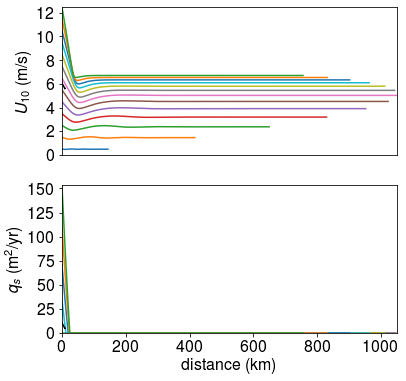

In [378]:
# each forcing scenario in color and the net transect in black

fig = plt.gcf()

plt.subplot(211)
for i in range(len(U1_t)):
    plt.plot(X1_t[i]*m2km,U1_t[i])
plt.plot(X_t*m2km,U_t,'k')
plt.xlim(0,np.max(X1_t*m2km))
plt.ylim(0,np.max(U1_t))
plt.ylabel('$U_{10}$ (m/s)',fontsize=fs*2)
plt.xticks([],[])
plt.yticks(fontsize=fs*2)

plt.subplot(212)
for i in range(len(U1_t)):
    plt.plot(X1_t[i]*m2km,Q1_t[i]/s2y)
plt.plot(X_t*m2km,Q_t/s2y,'k')
plt.xlim(0,np.max(X1_t*m2km))
plt.ylim(0,np.max(Q1_t)/s2y)
plt.xlabel('distance (km)',fontsize=fs*2)
plt.ylabel('$q_{s}$ (m$^{2}$/yr)',fontsize=fs*2)
plt.xticks(fontsize=fs*2)
plt.yticks(fontsize=fs*2)
fig.set_size_inches(6, 6, forward=True)

In [379]:
# get the range in wind speeds measured at 2 m for each met tower across a range of forcing conditions

Ng = 10 # number of forcing steps
G = np.linspace(1,50,Ng) # the geostrophic flow speed forcing

# theory as above
a0 = a(G,z_m[0],z00,Z,L0) 
A0 = G/(1-1j*a0/f)
a1 = a(G,z_m[0],z01,Z,L0)

e1 = np.exp(-(a1[:,np.newaxis]+1j*f)*t_t[np.newaxis,:])
B1 = G/(1-1j*a1/f)
A = (A0[:,np.newaxis]-B1[:,np.newaxis])*e1+B1[:,np.newaxis]
U = np.abs(A)

T = np.arctan2(A.imag,A.real)

S = t_t*U
X = S*np.cos(T)

# 2 m wind speed for each met tower because s_X_o is the distance from the boundary
U0a = U[np.arange(0,Ng),np.argmin(np.abs(X-s_a_o),axis=-1)]
U0b = U[np.arange(0,Ng),np.argmin(np.abs(X-s_b_o),axis=-1)]
U0c = U[np.arange(0,Ng),np.argmin(np.abs(X-s_c_o),axis=-1)]

In [380]:
# for a fixed geostrophic condition, report the saturation values for the chosen
# White Sands roughnesses
G = 20 # fixed geostrophic wind speed
z = 10 # reference elevation in each scenario

a0 = a(G,z,z00,Z,L0)
A0 = G/(1-1j*a0/f)
a1 = a(G,z,z01,Z,L0)

e1 = np.exp(-(a1+1j*f)*t_t)
B1 = G/(1-1j*a1/f)
A1 = (A0-B1)*e1+B1
U1 = np.abs(A1)

T1 = np.arctan2(A1.imag,A1.real)

S1 = t_t*U1
X1 = S1*np.cos(T1)

Usat = np.abs(B1/A0)
Asat = np.arctan2(f,a0) - np.arctan2(f,a1)

U1s = np.abs((U1-np.abs(B1))/np.abs(B1))
envpi   = np.argwhere(U1s<eps)
indb = np.min(envpi)
LSb = X1[indb]

print('Saturated wind speed is %.4f times the outside wind'%Usat)
print('Saturated wind direction is %.1f degrees to the North of the outside wind'%(Asat*180/np.pi))
print('Saturation length is %.1f km downwind of the edge'%(LSb*m2km))

Saturated wind speed is 0.5084 times the outside wind
Saturated wind direction is 22.3 degrees to the North of the outside wind
Saturation length is 32.0 km downwind of the edge


In [381]:
# get theoretical speed and angle transects for different pairs of roughnesses
# as well as saturated values for the angle and speed changes, and the distance required for saturation
# also find the amount of net erosion and deposition we can expect some distance
# from the boundary between roughnesses

Nz0 = 100 # root of the number of difference roughnesses scenarios
G = 20 # fixed geostrophic wind speed
z = 10 # reference elevation in each scenario

z0_0 = np.logspace(-5,0,Nz0) # roughness length of upwind
z0_1 = z0_0 # roughness length of downwind
Z0_0,Z0_1 = np.meshgrid(z0_0,z0_1)
I,J = np.meshgrid(np.arange(0,Nz0),np.arange(0,Nz0))
Z0r = Z0_0/Z0_1
z0_0wsi = np.argmin(np.abs(z0_0-z00)) # indices of the closest scenario to the white sands theory
z0_1wsi = np.argmin(np.abs(z0_1-z01))

# same as above
a0 = a(G,z,Z0_0,Z,L0)
A0 = G/(1-1j*a0/f)
a1 = a(G,z,Z0_1,Z,L0)

e1 = np.exp(-(a1[:,:,np.newaxis]+1j*f)*t_t[np.newaxis,np.newaxis,:])
B1 = G/(1-1j*a1/f)
A1 = (A0[:,:,np.newaxis]-B1[:,:,np.newaxis])*e1+B1[:,:,np.newaxis]
U1 = np.abs(A1)

T1 = np.arctan2(A1.imag,A1.real)
dT = (T1 - np.arctan2(A0[:,:,np.newaxis].imag,A0[:,:,np.newaxis].real))*180/np.pi

S1 = t_t*U1
X1 = S1*np.cos(T1)

Q1 = flux(U1,z,z00)

# do exner to get the deposition rate
# get the rate at a fixed distance downwind (here the along-wind length of white sands at the met transect)
DZDT = -np.diff(Q1,axis=-1)/np.diff(X1,axis=-1)/phi
DZDTr = DZDT[J,I,np.argmin(np.abs(X1-s_r_m),axis=-1)]
# this rate needs to be scaled for intermittency
# done by scaling such that the white sands roughness pair scenario has the same flux at the boundary
# as the theoretical transect incorporating the measured likelihood of winds at met a
factor = Q_t[0]/Q1[z0_1wsi,z0_0wsi][0]
DZDTr = DZDTr*factor
DZDTr[DZDTr==0] = np.nan # get rid of zero deposition rate values for plotting

# saturated ratio of wind speed and veering angle between upwind and downwind 
Usat = np.abs(B1/A0)
Asat = np.arctan2(f,a0) - np.arctan2(f,a1)

print('The intermittency factor is %.4f'%factor)

The intermittency factor is 0.0541


In [382]:
# get the saturation distance 
# defined as the closest distance normal to the boundary where the wind speed is 
# within 1% of equilibrium with downwind conditions
U1s = np.abs((U1-np.abs(B1[:,:,np.newaxis]))/np.abs(B1[:,:,np.newaxis]))

LSb = np.zeros_like(Z0r)

for i in np.arange(0,np.shape(U1s)[0]):
    for j in np.arange(0,np.shape(U1s)[1]):
        envpi   = np.argwhere(U1s[i,j,:]<eps)
        indb = np.min(envpi)
        LSb[i,j] = X1[i,j,indb] #find distance associated with convergence to (1+-eps)*Uinf

### LES and Deposition comparison data

In [383]:
# to show profiles of damping frequency
# do examples from 1) inverted from wang & anderson LES,
# inverted from the upwind lidar profile,
# and the values from the white sands scenario (momen & bou-zeid method)

tempu = np.mean(u_l1a[:-1],axis=1)

temp_path = 'wsnm3.csv' # grab data taken from plot in wang & anderson
tempdata = pd.read_csv(temp_path,delimiter=',',header=-1)
uhat_les = np.asarray(tempdata.iloc[:,0])
zhat_les = np.asarray(tempdata.iloc[:,1])
H_les = 100
us_les = 1
z_les = zhat_les*H_les
u_les = uhat_les*us_les

g_les = 20 #u_les[-1]
g_l = gfromu(tempu[-1],z_l1[-2],z00)
g_mbz = g_l

# a_l = f*((g_l/tempu)**2-1)**0.5
# a_les = f*((g_les/u_les)**2-1)**0.5

a_l = f*(g_l/tempu-1)
a_les = f*(g_les/u_les-1)

al0_mbz = a(g_mbz,z_t,z00,Z,L0)
al1_mbz = a(g_mbz,z_t,z01,Z,L0)

In [426]:
# grab the OSL measured deposition rates at white sands from kocurek et al 2007
dzdtr_k07 = [0.5,0.9,2.5,1.4,1.1,1.4]
dzdtr_k07av = np.mean(dzdtr_k07)
dzdtr_k0725 = np.percentile(dzdtr_k07,25)
dzdtr_k0775 = np.percentile(dzdtr_k07,75)
dzdtr_k070 = np.percentile(dzdtr_k07,0)
dzdtr_k07100 = np.percentile(dzdtr_k07,100)

x_k07, y_k07 = transform(p_lonlat, p_lidar, -106.265287, 32.820668)
tempx2 = np.min(upwindVertups_o[:,0])
tempy2 = y_k07 + (tempx2-x_k07)*np.tan(af0*np.pi/180)
tempp3 = LineString([(x_k07,y_k07),(tempx2,tempy2)]).intersection(upwind_boundary_o)
s_k07  = LineString([(tempp3.coords[0][0],tempp3.coords[0][1]),(x_k07, y_k07)]).length
s_k07

DZDTr_k07 = DZDT[J,I,np.argmin(np.abs(X1-s_k07),axis=-1)]
DZDTr_k07 = DZDTr_k07*factor
DZDTr_k07[DZDTr_k07==0] = np.nan # get rid of zero deposition rate values for plotting


### Data-driven alpha theory

In [385]:
def a_calc(z):
    az0,az1 = np.polyfit(np.log10(z_l1[:-1]),np.log10(a_l),deg=1)

    return 10**az1*z**az0

def a_les_calc(z):
    z_new = np.hstack((1,z_les,100))
    a_new = np.hstack((a_les[0],a_les,a_les[-1]))
    
    f = interp1d(z_new,a_new)
    return f(z)

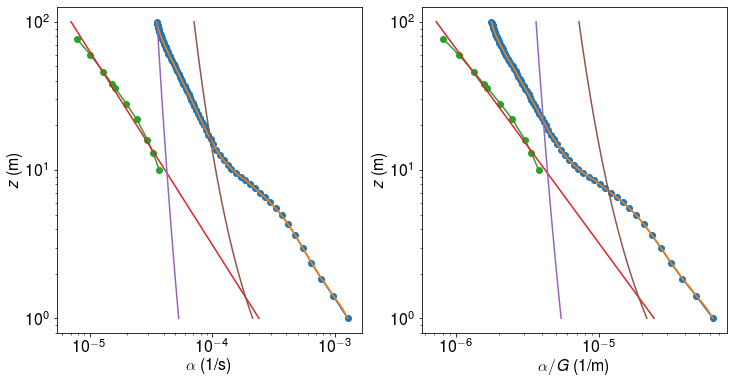

In [386]:
z_temp = np.logspace(0,2,100)

fig = plt.gcf()

plt.subplot(121)
plt.plot(a_les,z_les,'-o')
plt.plot(a_les_calc(z_temp),z_temp)

plt.plot(a_l,z_l1[:-1],'-o')
plt.plot(a_calc(z_temp),z_temp)

plt.plot(al0_mbz,z_t)
plt.plot(al1_mbz,z_t)

plt.yscale('log')
plt.xscale('log')

plt.xlabel('$\\alpha$ (1/s)',fontsize=fs*2)
plt.ylabel('$z$ (m)',fontsize=fs*2)
plt.xticks(fontsize=fs*2)
plt.yticks(fontsize=fs*2)

plt.subplot(122)
plt.plot(a_les/g_les,z_les,'-o')
plt.plot(a_les_calc(z_temp)/g_les,z_temp)

plt.plot(a_l/g_l,z_l1[:-1],'-o')
plt.plot(a_calc(z_temp)/g_l,z_temp)

plt.plot(al0_mbz/g_mbz,z_t)
plt.plot(al1_mbz/g_mbz,z_t)

plt.yscale('log')
plt.xscale('log')

plt.xlabel('$\\alpha/G$ (1/m)',fontsize=fs*2)
plt.ylabel('$z$ (m)',fontsize=fs*2)
plt.xticks(fontsize=fs*2)
plt.yticks(fontsize=fs*2)

fig.set_size_inches(12, 6, forward=True)

In [387]:
T = 60*60*80 # total model time
t_t = np.logspace(0,np.log10(T),Nt) # the time step grid

# get a theoretical transect in wind speed and flux
# because 1) distance travelled depends on speed,
# 2) 10 m speeds are non-linearly related to forcing
# 3) sediment flux is a threshold phenomena,
# and 4) speeds occur as a distribution in reality,
# care must be taken to make sure this transect is equivalent to reality

# find the relevant geostrophic forcing wind for each value in the aligned 10 m 
# winds from the upwind met tower distribution
G_t = np.empty_like(ubinmids)
for i in range(len(G_t)):
    G_t[i] = gfromu(ubinmids[i],z_m[2],z00)

a0_t_DD = a_calc(z_m[2])/g_l*G_t # upwind damping for the BCs
A0_t_DD = G_t/(1-1j*a0_t_DD/f) # upwind equilibrium wind vector 
a1_t_DD = a_les_calc(z_m[2])/g_les*G_t # downwind damping for the BCs

e1_t_DD = np.exp(-(a1_t_DD[:,np.newaxis]+1j*f)*t_t[np.newaxis,:]) # decay downwind of boundary
B1_t_DD = G_t/(1-1j*a1_t_DD/f) # downwind equilibrium for the BCs 
A1_t_DD = (A0_t_DD[:,np.newaxis]-B1_t_DD[:,np.newaxis])*e1_t_DD+B1_t_DD[:,np.newaxis] # downwind wind vector evolution
U1_t_DD = np.abs(A1_t_DD) # downwind wind speed evolution

T1_t_DD = np.arctan2(A1_t_DD.imag,A1_t_DD.real) # upwind equilibrium wind angle
# downwind wind angle evolution relative to upwind
dT1_t_DD = (T1_t_DD - np.arctan2(A0_t_DD[:,np.newaxis].imag,A0_t_DD[:,np.newaxis].real))*180/np.pi

S1_t_DD = t_t*U1_t_DD # distance travelled in lagrangian f.o.r. from boundary
X1_t_DD = S1_t_DD*np.cos(T1_t_DD) # distanced travelled normal to boundary

Q1_t_DD = flux(U1_t_DD,z_m[2],z00) # sediment flux from winds

# put this range of forcing conditions together such that they occur with the same
# likelihood as reality
tempu_DD = U1_t_DD*pu2a[:,np.newaxis] # wind speeds scaled by likelihood of being measured at met_a
tempq_DD = Q1_t_DD*pu2a[:,np.newaxis] # sediment flux scaled as above

# create transects
X_tbins = np.linspace(0,np.ceil(np.max(sr)/100)*100,int((np.ceil(np.max(sr)/100)))+1)
X_t = X_tbins[1:] - np.diff(X_tbins)[0]/2
U_t_DD = np.empty([np.shape(X_t)[0],np.shape(tempu_DD)[0]])
Q_t_DD = np.empty([np.shape(X_t)[0],np.shape(tempu_DD)[0]])

# for a given distance bin downwind, get the mean of the speeds and fluxes for each forcing condition
for i in range(len(X_t)):
    for j in range(len(tempu_DD)):
        U_t_DD[i,j] = np.mean(tempu_DD[j][(X1_t_DD[j]>X_tbins[i])&(X1_t_DD[j]<=X_tbins[i+1])])
        Q_t_DD[i,j] = np.mean(tempq_DD[j][(X1_t_DD[j]>X_tbins[i])&(X1_t_DD[j]<=X_tbins[i+1])])

# get the net speed and flux transect
U_t_DD = np.sum(U_t_DD,axis=1)
Q_t_DD = np.sum(Q_t_DD,axis=1)

/home/andrew/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/andrew/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


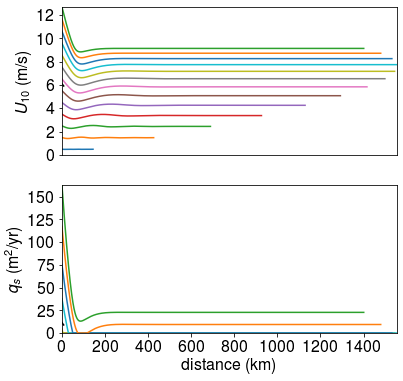

In [388]:
# each forcing scenario in color and the net transect in black

fig = plt.gcf()

plt.subplot(211)
for i in range(len(U1_t_DD)):
    plt.plot(X1_t_DD[i]*m2km,U1_t_DD[i])
plt.plot(X_t*m2km,U_t_DD,'k')
plt.xlim(0,np.max(X1_t_DD*m2km))
plt.ylim(0,np.max(U1_t_DD))
plt.ylabel('$U_{10}$ (m/s)',fontsize=fs*2)
plt.xticks([],[])
plt.yticks(fontsize=fs*2)

plt.subplot(212)
for i in range(len(U1_t_DD)):
    plt.plot(X1_t_DD[i]*m2km,Q1_t_DD[i]/s2y)
plt.plot(X_t*m2km,Q_t_DD/s2y,'k')
plt.xlim(0,np.max(X1_t_DD*m2km))
plt.ylim(0,np.max(Q1_t_DD)/s2y)
plt.xlabel('distance (km)',fontsize=fs*2)
plt.ylabel('$q_{s}$ (m$^{2}$/yr)',fontsize=fs*2)
plt.xticks(fontsize=fs*2)
plt.yticks(fontsize=fs*2)


fig.set_size_inches(6, 6, forward=True)

In [389]:
# get the range in wind speeds measured at 2 m for each met tower across a range of forcing conditions

Ng = 10 # number of forcing steps
G = np.linspace(1,50,Ng) # the geostrophic flow speed forcing

# theory as above
a0_DD = a_calc(z_m[0])/g_l*G # upwind damping for the BCs
A0_DD = G/(1-1j*a0_DD/f) # upwind equilibrium wind vector 
a1_DD = a_les_calc(z_m[0])/g_les*G # downwind damping for the BCs

e1_DD = np.exp(-(a1_DD[:,np.newaxis]+1j*f)*t_t[np.newaxis,:])
B1_DD = G/(1-1j*a1_DD/f)
A_DD = (A0_DD[:,np.newaxis]-B1_DD[:,np.newaxis])*e1_DD+B1_DD[:,np.newaxis]
U_DD = np.abs(A_DD)

T_DD = np.arctan2(A_DD.imag,A_DD.real)

S_DD = t_t*U_DD
X_DD = S_DD*np.cos(T_DD)

# 2 m wind speed for each met tower because s_X_o is the distance from the boundary
U0a_DD = U_DD[np.arange(0,Ng),np.argmin(np.abs(X_DD-s_a_o),axis=-1)]
U0b_DD = U_DD[np.arange(0,Ng),np.argmin(np.abs(X_DD-s_b_o),axis=-1)]
U0c_DD = U_DD[np.arange(0,Ng),np.argmin(np.abs(X_DD-s_c_o),axis=-1)]

(-6, 6)

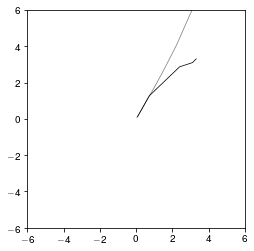

In [390]:
plt.plot(U0a-U0b,U0a-U0c,'grey',lw=lw*1.5)
plt.plot(U0a_DD-U0b_DD,U0a_DD-U0c_DD,'k',lw=lw*1.5)
plt.axis('square')
plt.xlim(-6,6)
plt.ylim(-6,6)

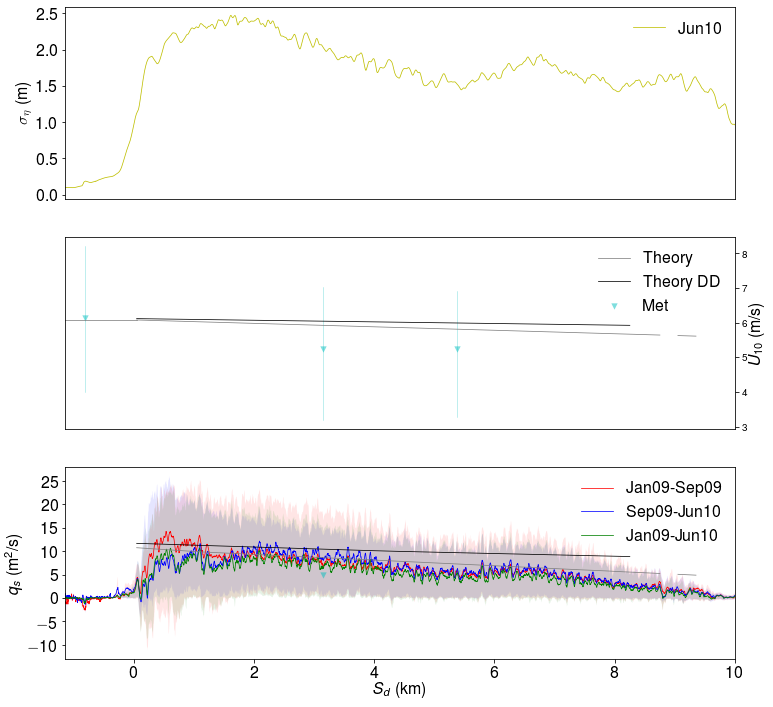

In [391]:
lw = 0.5
S = 40
A = 0.5

i = 4800
templ = LineString([(np.min(xr),yr[i]),(np.max(xr),yr[i])])
tempp = templ.intersection(upwind_boundary_r)
uwi = np.argmin(np.abs(xr-tempp.coords[0][0]))

fig = plt.gcf()

ax0 = plt.subplot(311)

plt.plot(sr*m2km,stdr_jun10savg,c='y',lw=lw*1.5,label='Jun10')

plt.legend(frameon=False,fontsize=fs*2)

plt.ylabel('$\\sigma_{\\eta}$ (m)',fontsize=fs*2)

plt.xticks([],[])
plt.yticks(fontsize=fs*2)

plt.xlim((xr[np.min(np.argwhere(~np.isnan(zr_jun10[i,:])))]-xr[uwi])*m2km,10)

ax1 = plt.subplot(312)

plt.scatter([s_a_o*m2km,s_b_o*m2km,s_c_o*m2km],[np.mean(u2aca),np.mean(u2bca),np.mean(u2cca)],c='c',marker='v',s=S,alpha=A,lw=0,label='Met')

plt.plot([s_a_o*m2km,s_a_o*m2km],[np.percentile(u2aca,25),np.percentile(u2aca,75)],c='c',alpha=A,lw=lw)
plt.plot([s_b_o*m2km,s_b_o*m2km],[np.percentile(u2bca,25),np.percentile(u2bca,75)],c='c',alpha=A,lw=lw)
plt.plot([s_c_o*m2km,s_c_o*m2km],[np.percentile(u2cca,25),np.percentile(u2cca,75)],c='c',alpha=A,lw=lw)

plt.plot(X_t*m2km,U_t,'grey',lw=lw*1.5,label='Theory')
plt.plot(X_t*m2km,U_t_DD,'k',lw=lw*1.5,label='Theory DD')

plt.plot([(xr[np.min(np.argwhere(~np.isnan(zr_jun10[i,:])))]-xr[uwi])*m2km,X_t[0]*m2km],[U_t[0],U_t[0]],'grey',lw=lw*1.5)

plt.legend(frameon=False,fontsize=fs*2)

plt.ylabel('$U_{10}$ (m/s)',fontsize=fs*2)

plt.xticks([],[])
plt.yticks(fontsize=fs*2)

plt.xlim((xr[np.min(np.argwhere(~np.isnan(zr_jun10[i,:])))]-xr[uwi])*m2km,10)

ax1.yaxis.set_label_position("right")
ax1.yaxis.tick_right()

ax2 = plt.subplot(313)

plt.plot(sr*m2km,qavg[0]/s2y,c='r',lw=lw*1.5,label='Jan09-Sep09')
plt.fill_between(sr*m2km,qp25[0]/s2y,qp75[0]/s2y,alpha=0.1,lw=0,color='b')

plt.plot(sr*m2km,qavg[1]/s2y,c='b',lw=lw*1.5,label='Sep09-Jun10')
plt.fill_between(sr*m2km,qp25[1]/s2y,qp75[1]/s2y,alpha=0.1,lw=0,color='r')

plt.plot(sr*m2km,qavg[2]/s2y,c='g',lw=lw*1.5,label='Jan09-Jun10')
plt.fill_between(sr*m2km,qp25[2]/s2y,qp75[2]/s2y,alpha=0.1,lw=0,color='g')

plt.scatter([s_b_o*m2km,s_c_o*m2km],[q2bca_av/s2y,q2cca_av/s2y],c='c',marker='v',s=S,alpha=A,lw=0)

plt.plot(X_t*m2km,Q_t/s2y,'grey',lw=lw*1.5)
plt.plot(X_t*m2km,Q_t_DD/s2y,'k',lw=lw*1.5)

plt.legend(frameon=False,fontsize=fs*2)

plt.xlabel('$S_d$ (km)',fontsize=fs*2)
plt.ylabel('$q_s$ (m$^2$/s)',fontsize=fs*2)

plt.xticks(fontsize=fs*2)
plt.yticks(fontsize=fs*2)

plt.xlim((xr[np.min(np.argwhere(~np.isnan(zr_jun10[i,:])))]-xr[uwi])*m2km,10)

fig.set_size_inches(12,12, forward=True)

### Data-driven roughness theory

In [392]:
def step(t,targetX,G,sigma,oldA):
    z01 = sigma/z01_sigma_sf
    a1_t_SR = a(G,z_m[2],z01,Z,L0) # downwind damping for the BCs

    e1_t_SR = np.exp(-(a1_t_SR+1j*f)*t) # decay downwind of boundary
    B1_t_SR = G/(1-1j*a1_t_SR/f) # downwind equilibrium for the BCs 
    A1_t_SR = (oldA-B1_t_SR)*e1_t_SR+B1_t_SR # downwind wind vector evolution
    U1_t_SR = np.abs(A1_t_SR) # downwind wind speed evolution

    T1_t_SR = np.arctan2(A1_t_SR.imag,A1_t_SR.real) # upwind equilibrium wind angle

    S1_t_SR = t*U1_t_SR # distance travelled in lagrangian f.o.r. from boundary
    X1_t_SR = S1_t_SR*np.cos(T1_t_SR) # distanced travelled normal to boundary
    
    return X1_t_SR-targetX

def get_t(targetX,G,sigma,oldA):
    return root(step,1e-3,args=(targetX,G,sigma,oldA),method='lm').x[0]

In [393]:
z01_sigma_sf = 10

G_t = np.empty_like(ubinmids)
for i in range(len(G_t)):
    G_t[i] = gfromu(ubinmids[i],z_m[2],z00)

targetX = 1

X1_t_SR = np.empty((len(G_t),len(sr[sr>0])))
U1_t_SR = np.empty((len(G_t),len(sr[sr>0])))


for i in np.arange(0,len(G_t)):
    
    a0_t_SR = a(G_t[i],z_m[2],z00,Z,L0) # upwind damping for the BCs
    A0_t_SR = G_t[i]/(1-1j*a0_t_SR/f) # upwind equilibrium wind vector

    for j in np.arange(0,len(sr[sr>0])):
        if j==0:
            Aold = A0_t_SR
        else:
            Aold = A1_t_SR

        t_temp = get_t(targetX,G_t[i],stdr_jun10savg[sr>0][j],Aold)

        z01 = stdr_jun10savg[sr>0][j]/z01_sigma_sf
        a1_t_SR = a(G_t[i],z_m[2],z01,Z,L0) # downwind damping for the BCs

        e1_t_SR = np.exp(-(a1_t_SR+1j*f)*t_temp) # decay downwind of boundary
        B1_t_SR = G_t[i]/(1-1j*a1_t_SR/f) # downwind equilibrium for the BCs 
        A1_t_SR = (Aold-B1_t_SR)*e1_t_SR+B1_t_SR # downwind wind vector evolution

        U1_t_SR[i,j] = np.abs(A1_t_SR) # downwind wind speed evolution
        X1_t_SR[i,j] = sr[sr>0][j] # distanced travelled normal to boundary


Q1_t_SR = flux(U1_t_SR,z_m[2],z00) # sediment flux from winds

# put this range of forcing conditions together such that they occur with the same
# likelihood as reality
tempu_SR = U1_t_SR*pu2a[:,np.newaxis] # wind speeds scaled by likelihood of being measured at met_a
tempq_SR = Q1_t_SR*pu2a[:,np.newaxis] # sediment flux scaled as above

# create transects
X_tbins = np.linspace(0,np.ceil(np.max(sr)/100)*100,int((np.ceil(np.max(sr)/100)))+1)
X_t = X_tbins[1:] - np.diff(X_tbins)[0]/2
U_t_SR = np.empty([np.shape(X_t)[0],np.shape(tempu_SR)[0]])
Q_t_SR = np.empty([np.shape(X_t)[0],np.shape(tempu_SR)[0]])

# for a given distance bin downwind, get the mean of the speeds and fluxes for each forcing condition
for i in range(len(X_t)):
    for j in range(len(tempu_SR)):
        U_t_SR[i,j] = np.mean(tempu_SR[j][(X1_t_SR[j]>X_tbins[i])&(X1_t_SR[j]<=X_tbins[i+1])])
        Q_t_SR[i,j] = np.mean(tempq_SR[j][(X1_t_SR[j]>X_tbins[i])&(X1_t_SR[j]<=X_tbins[i+1])])

# get the net speed and flux transect
U_t_SR = np.sum(U_t_SR,axis=1)
Q_t_SR = np.sum(Q_t_SR,axis=1)

/home/andrew/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.


In [394]:
# get the range in wind speeds measured at 2 m for each met tower across a range of forcing conditions

Ng = 10 # number of forcing steps
G = np.linspace(1,50,Ng) # the geostrophic flow speed forcing

X_SR = np.empty((len(G),len(sr[sr>0])))
U_SR = np.empty((len(G),len(sr[sr>0])))


for i in np.arange(0,len(G)):
    
    a0_SR = a(G[i],z_m[2],z00,Z,L0) # upwind damping for the BCs
    A0_SR = G[i]/(1-1j*a0_SR/f) # upwind equilibrium wind vector

    for j in np.arange(0,len(sr[sr>0])):
        if j==0:
            Aold = A0_SR
        else:
            Aold = A_SR

        t_temp = get_t(targetX,G[i],stdr_jun10savg[sr>0][j],Aold)

        z01 = stdr_jun10savg[sr>0][j]/z01_sigma_sf
        a_SR = a(G[i],z_m[2],z01,Z,L0) # downwind damping for the BCs

        e_SR = np.exp(-(a_SR+1j*f)*t_temp) # decay downwind of boundary
        B_SR = G[i]/(1-1j*a_SR/f) # downwind equilibrium for the BCs 
        A_SR = (Aold-B_SR)*e_SR+B_SR # downwind wind vector evolution

        U_SR[i,j] = np.abs(A_SR) # downwind wind speed evolution
        X_SR[i,j] = sr[sr>0][j] # distanced travelled normal to boundary

# 2 m wind speed for each met tower because s_X_o is the distance from the boundary
U0a_SR = U_SR[np.arange(0,Ng),np.argmin(np.abs(X_SR-s_a_o),axis=-1)]
U0b_SR = U_SR[np.arange(0,Ng),np.argmin(np.abs(X_SR-s_b_o),axis=-1)]
U0c_SR = U_SR[np.arange(0,Ng),np.argmin(np.abs(X_SR-s_c_o),axis=-1)]

(-6, 6)

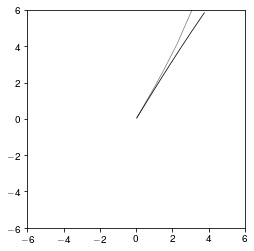

In [395]:
plt.plot(U0a-U0b,U0a-U0c,'grey',lw=lw*1.5)
plt.plot(U0a_SR-U0b_SR,U0a_SR-U0c_SR,'k',lw=lw*1.5)
plt.axis('square')
plt.xlim(-6,6)
plt.ylim(-6,6)

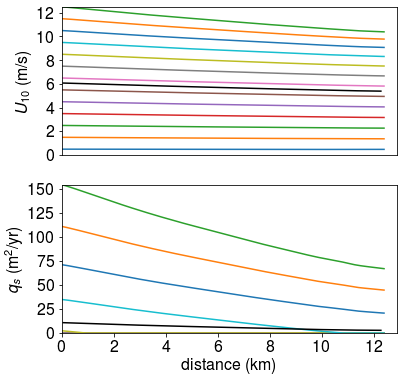

In [396]:
# each forcing scenario in color and the net transect in black

fig = plt.gcf()

plt.subplot(211)
for i in range(len(U1_t_SR)):
    plt.plot(X1_t_SR[i]*m2km,U1_t_SR[i])
plt.plot(X_t*m2km,U_t_SR,'k')
plt.xlim(0,np.max(X1_t_SR*m2km))
plt.ylim(0,np.nanmax(U1_t_SR))
plt.ylabel('$U_{10}$ (m/s)',fontsize=fs*2)
plt.xticks([],[])
plt.yticks(fontsize=fs*2)

plt.subplot(212)
for i in range(len(U1_t_SR)):
    plt.plot(X1_t_SR[i]*m2km,Q1_t_SR[i]/s2y)
plt.plot(X_t*m2km,Q_t_SR/s2y,'k')
plt.xlim(0,np.max(X1_t_SR*m2km))
plt.ylim(0,np.nanmax(Q1_t_SR)/s2y)
plt.xlabel('distance (km)',fontsize=fs*2)
plt.ylabel('$q_{s}$ (m$^{2}$/yr)',fontsize=fs*2)
plt.xticks(fontsize=fs*2)
plt.yticks(fontsize=fs*2)
fig.set_size_inches(6, 6, forward=True)

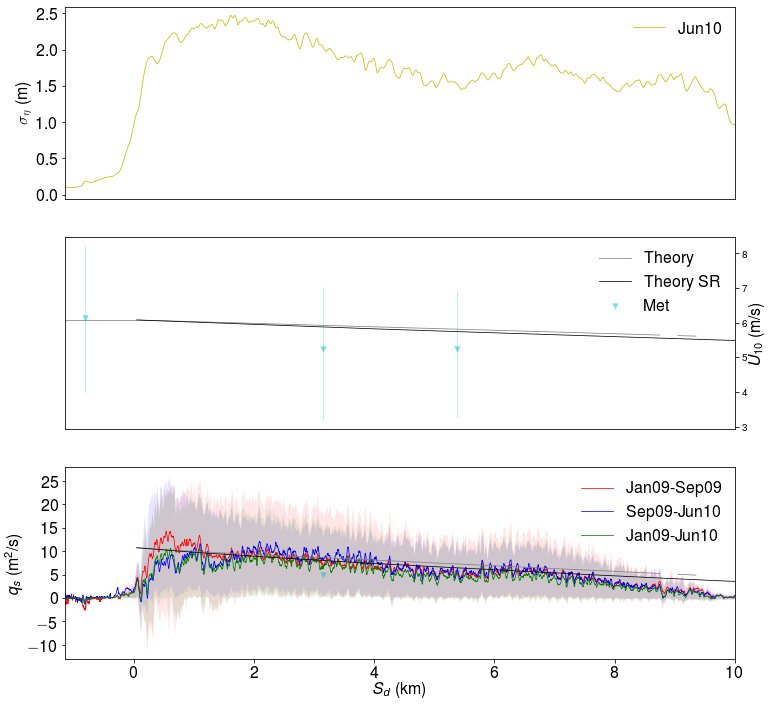

In [397]:
lw = 0.5
S = 40
A = 0.5

i = 4800
templ = LineString([(np.min(xr),yr[i]),(np.max(xr),yr[i])])
tempp = templ.intersection(upwind_boundary_r)
uwi = np.argmin(np.abs(xr-tempp.coords[0][0]))

fig = plt.gcf()

ax0 = plt.subplot(311)

plt.plot(sr*m2km,stdr_jun10savg,c='y',lw=lw*1.5,label='Jun10')

plt.legend(frameon=False,fontsize=fs*2)

plt.ylabel('$\\sigma_{\\eta}$ (m)',fontsize=fs*2)

plt.xticks([],[])
plt.yticks(fontsize=fs*2)

plt.xlim((xr[np.min(np.argwhere(~np.isnan(zr_jun10[i,:])))]-xr[uwi])*m2km,10)

ax1 = plt.subplot(312)

plt.scatter([s_a_o*m2km,s_b_o*m2km,s_c_o*m2km],[np.mean(u2aca),np.mean(u2bca),np.mean(u2cca)],c='c',marker='v',s=S,alpha=A,lw=0,label='Met')

plt.plot([s_a_o*m2km,s_a_o*m2km],[np.percentile(u2aca,25),np.percentile(u2aca,75)],c='c',alpha=A,lw=lw)
plt.plot([s_b_o*m2km,s_b_o*m2km],[np.percentile(u2bca,25),np.percentile(u2bca,75)],c='c',alpha=A,lw=lw)
plt.plot([s_c_o*m2km,s_c_o*m2km],[np.percentile(u2cca,25),np.percentile(u2cca,75)],c='c',alpha=A,lw=lw)

plt.plot(X_t*m2km,U_t,'grey',lw=lw*1.5,label='Theory')
plt.plot(X_t*m2km,U_t_SR,'k',lw=lw*1.5,label='Theory SR')

plt.plot([(xr[np.min(np.argwhere(~np.isnan(zr_jun10[i,:])))]-xr[uwi])*m2km,X_t[0]*m2km],[U_t[0],U_t[0]],'grey',lw=lw*1.5)

plt.legend(frameon=False,fontsize=fs*2)

plt.ylabel('$U_{10}$ (m/s)',fontsize=fs*2)

plt.xticks([],[])
plt.yticks(fontsize=fs*2)

plt.xlim((xr[np.min(np.argwhere(~np.isnan(zr_jun10[i,:])))]-xr[uwi])*m2km,10)

ax1.yaxis.set_label_position("right")
ax1.yaxis.tick_right()

ax2 = plt.subplot(313)

plt.plot(sr*m2km,qavg[0]/s2y,c='r',lw=lw*1.5,label='Jan09-Sep09')
plt.fill_between(sr*m2km,qp25[0]/s2y,qp75[0]/s2y,alpha=0.1,lw=0,color='b')

plt.plot(sr*m2km,qavg[1]/s2y,c='b',lw=lw*1.5,label='Sep09-Jun10')
plt.fill_between(sr*m2km,qp25[1]/s2y,qp75[1]/s2y,alpha=0.1,lw=0,color='r')

plt.plot(sr*m2km,qavg[2]/s2y,c='g',lw=lw*1.5,label='Jan09-Jun10')
plt.fill_between(sr*m2km,qp25[2]/s2y,qp75[2]/s2y,alpha=0.1,lw=0,color='g')

plt.scatter([s_b_o*m2km,s_c_o*m2km],[q2bca_av/s2y,q2cca_av/s2y],c='c',marker='v',s=S,alpha=A,lw=0)

plt.plot(X_t*m2km,Q_t/s2y,'grey',lw=lw*1.5)
plt.plot(X_t*m2km,Q_t_SR/s2y,'k',lw=lw*1.5)

plt.legend(frameon=False,fontsize=fs*2)

plt.xlabel('$S_d$ (km)',fontsize=fs*2)
plt.ylabel('$q_s$ (m$^2$/s)',fontsize=fs*2)

plt.xticks(fontsize=fs*2)
plt.yticks(fontsize=fs*2)

plt.xlim((xr[np.min(np.argwhere(~np.isnan(zr_jun10[i,:])))]-xr[uwi])*m2km,10)

fig.set_size_inches(12,12, forward=True)

# Figures

## Figure 1

In [398]:
ds = gdal.Open(sep09, gdal.GA_ReadOnly)
rb = ds.GetRasterBand(1)
metaxy = ds.GetGeoTransform()
z_sep09 = np.flip(rb.ReadAsArray(),axis=0)
x = metaxy[0]+metaxy[1]*np.arange(0,np.shape(z_sep09)[1])
y = np.flip(metaxy[3]+metaxy[5]*np.arange(0,np.shape(z_sep09)[0]))
X,Y = np.meshgrid(x,y)

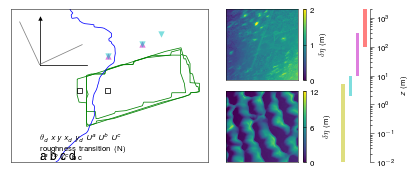

In [515]:
lw = 0.5
S = 40
A = 0.5

Xi1 = 3.76e+5
Xf1 = Xi1 + 5e+2
Yi1 = 3.633e+6
Yf1 = Yi1 + 5e+2

xi1 = np.argmin(np.abs(x-Xi1))
xf1 = np.argmin(np.abs(x-Xf1))
yi1 = np.argmin(np.abs(y-Yi1))
yf1 = np.argmin(np.abs(y-Yf1))

Xi2 = 3.79e+5
Xf2 = Xi2 + 5e+2
Yi2 = 3.633e+6
Yf2 = Yi2 + 5e+2

xi2 = np.argmin(np.abs(x-Xi2))
xf2 = np.argmin(np.abs(x-Xf2))
yi2 = np.argmin(np.abs(y-Yi2))
yf2 = np.argmin(np.abs(y-Yf2))

uw_boundary = LineCollection([upwind_boundary_o], alpha=1,color='b', lw=lw*1.5)
jan09_domain = PolygonPatch(jan09_domain_o, fc='none', ec='g', lw=lw*1.5)
sep09_domain = PolygonPatch(sep09_domain_o, fc='none', ec='g', lw=lw*1.5)
jun10_domain = PolygonPatch(jun10_domain_o, fc='none', ec='g', lw=lw*1.5)

box1 = PolygonPatch(Polygon([(Xi1,Yi1),(Xi1,Yf1),(Xf1,Yf1),(Xf1,Yi1)]), fc='none', ec='k', lw=lw*1.5)
box2 = PolygonPatch(Polygon([(Xi2,Yi2),(Xi2,Yf2),(Xf2,Yf2),(Xf2,Yi2)]), fc='none', ec='k', lw=lw*1.5)

ds = 5e+3
x00 = 3.72e+5
y00 = 3.636e+6

cu = 'c'
ca = 'r'
cs = 'y'
cr = 'm'

dune = Rectangle([0.003,0.001],0.0015,5-0.001,linewidth=0,edgecolor='none',facecolor=cs,alpha=A,zorder=-1)
met = Rectangle([0.006,2],0.0015,10-2,linewidth=0,edgecolor='none',facecolor=cu,alpha=A,zorder=-1)
lidar = Rectangle([0.009,10],0.0015,300-10,linewidth=0,edgecolor='none',facecolor=cr,alpha=A,zorder=-1)
abl = Rectangle([0.012,100],0.0015,2000-100,linewidth=0,edgecolor='none',facecolor=ca,alpha=A,zorder=-1)

fig = plt.gcf()

ax0 = plt.subplot2grid((2, 7), (0, 0), colspan=4, rowspan=2)

plt.text(x00,y00-2*ds,s='$\\theta_d$ $x$ $y$ $x_d$ $y_d$ $U^a$ $U^b$ $U^c$ \n roughness transition (N) \n $L^a$ $L^b$ $L^c$ b c',fontsize=fs)

ax0.add_collection(uw_boundary)
ax0.add_patch(jan09_domain)
ax0.add_patch(sep09_domain)
ax0.add_patch(jun10_domain)
ax0.add_patch(box1)
ax0.add_patch(box2)

ax0.scatter(x00,y00+ds,c='k',marker='^',s=20,lw=0)

ax0.scatter([x_a_o,x_b_o],[y_a_o,y_b_o],c='m',marker='^',s=S,alpha=A,lw=0)
ax0.scatter([x_a_o,x_b_o,x_c_o],[y_a_o,y_b_o,y_c_o],c='c',marker='v',s=S,alpha=A,lw=0)
ax0.plot([x00,x00+ds],[y00,y00],c='k',lw=lw*1.5)
ax0.plot([x00,x00],[y00,y00+ds],c='k',lw=lw*1.5)
ax0.plot([x00,x00+ds*np.cos(af0*np.pi/180)],[y00,y00+ds*np.sin(af0*np.pi/180)],c='grey',lw=lw*1.5)
ax0.plot([x00,x00-ds*np.sin(af0*np.pi/180)],[y00,y00+ds*np.cos(af0*np.pi/180)],c='grey',lw=lw*1.5)
ax0.axis('equal')
ax0.set_ylim(3.6275e+6,3.6400e+6)
ax0.set_xticks([],[])
ax0.set_yticks([],[])

plt.text(x00,y00-2*ds,'a b c d',fontsize=12)

ax1 = plt.subplot2grid((2, 7), (0, 4), colspan=2, rowspan=1)

z0 = 1194
dz = 2

s = ax1.pcolormesh(X[yi1:yf1,xi1:xf1],Y[yi1:yf1,xi1:xf1],z_sep09[yi1:yf1,xi1:xf1]-z0,vmin=0,vmax=dz,rasterized=True)
c1 = plt.colorbar(s,ax=ax1, ticks=[0, 1, 2])
c1.set_label('$\\delta\\eta$ (m)',fontsize=fs)
c1.ax.set_yticklabels(['0','1','2'],fontsize=fs)
ax1.axis('equal')
ax1.set_xticks([],[])
ax1.set_yticks([],[])

ax2 = plt.subplot2grid((2, 7), (1, 4), colspan=2, rowspan=1)

z0 = 1206
dz = 12

s2 = ax2.pcolormesh(X[yi2:yf2,xi2:xf2],Y[yi2:yf2,xi2:xf2],z_sep09[yi2:yf2,xi2:xf2]-z0,vmin=0,vmax=dz,rasterized=True)
c2 = plt.colorbar(s2,ax=ax2, ticks=[0, 6, 12])
c2.set_label('$\\delta\\eta$ (m)',fontsize=fs)
c2.ax.set_yticklabels(['0','6','12'],fontsize=fs)
ax2.axis('equal')
ax2.set_xticks([],[])
ax2.set_yticks([],[])

ax3 = plt.subplot2grid((2, 7), (0, 6), colspan=1, rowspan=2)

s = ax3.add_patch(met)
s = ax3.add_patch(lidar)
s = ax3.add_patch(dune)
s = ax3.add_patch(abl)

plt.ylabel('$z$ (m)',fontsize=fs)

plt.xlim([0,0.015])
plt.ylim([0.01,2000])

ax3.set_yscale('log')

ax3.spines['left'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax3.spines['bottom'].set_visible(False)

ax3.yaxis.tick_right()
ax3.yaxis.set_label_position("right")

plt.xticks([],[])
plt.yticks(fontsize=fs)

ax0.tick_params(width=lw)
for axis in ['top','bottom','left','right']:
    ax0.spines[axis].set_linewidth(lw)
ax1.tick_params(width=lw)
for axis in ['top','bottom','left','right']:
    ax1.spines[axis].set_linewidth(lw)
ax2.tick_params(width=lw)
for axis in ['top','bottom','left','right']:
    ax2.spines[axis].set_linewidth(lw)
ax3.tick_params(width=lw)
for axis in ['top','bottom','left','right']:
    ax3.spines[axis].set_linewidth(lw)
c1.ax.tick_params(width=lw,which='both',direction='in')
c1.outline.set_linewidth(lw)
c2.ax.tick_params(width=lw,which='both',direction='in')
c2.outline.set_linewidth(lw)

fig.subplots_adjust(wspace=0.5)
fig.subplots_adjust(hspace=0.15)
fig.subplots_adjust(bottom=0.05)
fig.subplots_adjust(top=0.96)
fig.subplots_adjust(right=0.9)
fig.subplots_adjust(left=0.01)

fig.set_size_inches(142.5/25.4, 142.5/25.4/2.4, forward=True)
plt.savefig('figures/fig1_0.pdf',dpi=300)

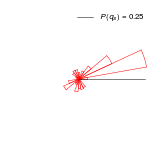

In [400]:
da = 15
mAf = np.arange(-180,180+da,da)
mAmidf = mAf[1:]-da/2
pq2aa = np.empty(len(mAmidf))
for i in range(len(mAmidf)):
    pq2aa[i] = np.sum(q2a[(aa>=mAf[i])&(aa<mAf[i+1])])
pq2aa = pq2aa/np.sum(q2a)

lw = 0.5

fig = plt.gcf()

ax0 = plt.subplot2grid((2, 7), (0, 0), colspan=3, rowspan=3,projection='polar')

for i in range(len(mAmidf)):
    sc = ax0.plot([(mAf[i]+af0)/180*np.pi,(mAf[i]+af0)/180*np.pi],[0,pq2aa[i]],color='r',lw=lw)
    sc = ax0.plot([(mAf[i+1]+af0)/180*np.pi,(mAf[i+1]+af0)/180*np.pi],[0,pq2aa[i]],color='r',lw=lw)
    
    tempt = (np.linspace(mAf[i],mAf[i+1],10)+af0)/180*np.pi
    tempr = np.ones_like(tempt)*pq2aa[i]
    sc = ax0.plot(tempt,tempr,color='r',lw=lw)
    
ax0.plot([0,0],[0,0.25],color='k',label='$P(q_s) = 0.25$',lw=lw)

plt.legend(frameon=False,fontsize=fs)
plt.axis('off')

fig.subplots_adjust(wspace=0.5)
fig.subplots_adjust(hspace=0.15)
fig.subplots_adjust(bottom=0.05)
fig.subplots_adjust(top=0.96)
fig.subplots_adjust(right=0.9)
fig.subplots_adjust(left=0.01)

fig.set_size_inches(142.5/25.4, 142.5/25.4/2.4, forward=True)
plt.savefig('figures/fig1_1.pdf',dpi=300)

## Figure 2

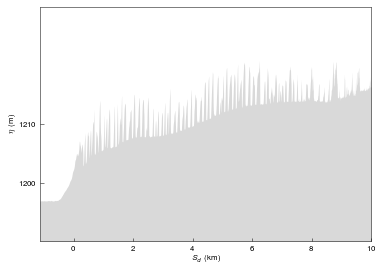

In [514]:
lw = 0.5

i = 4800
templ = LineString([(np.min(xr),yr[i]),(np.max(xr),yr[i])])
tempp = templ.intersection(upwind_boundary_r)
uwi = np.argmin(np.abs(xr-tempp.coords[0][0]))
zmin = 1190
zmax = 1230

fig = plt.gcf()

ax0 = plt.subplot(111)

plt.fill_between((xr-xr[uwi])*m2km,zr_jun10[i,:],np.ones(np.shape(xr)[0])*zmin,color='k',lw=0,alpha=0.15)

plt.xlabel('$S_d$ (km)',fontsize=fs)
plt.ylabel('$\\eta$ (m)',fontsize=fs)

plt.xticks(fontsize=fs)
plt.yticks([1200,1210],fontsize=fs)

plt.xlim((xr[np.min(np.argwhere(~np.isnan(zr_jun10[i,:])))]-xr[uwi])*m2km,10)
plt.ylim(zmin,zmax)

ax0.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax0.spines[axis].set_linewidth(lw) 

fig.subplots_adjust(hspace=0)
fig.subplots_adjust(bottom=0.12)
fig.subplots_adjust(top=0.99)
fig.subplots_adjust(right=0.92)
fig.subplots_adjust(left=0.1)
    
fig.set_size_inches(142.5/25.4, 142.5/25.4/1.5, forward=True)
plt.savefig('figures/fig2_0.pdf', dpi=300)

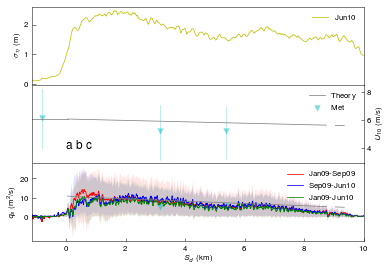

In [518]:
lw = 0.5
S = 40
A = 0.5

i = 4800
templ = LineString([(np.min(xr),yr[i]),(np.max(xr),yr[i])])
tempp = templ.intersection(upwind_boundary_r)
uwi = np.argmin(np.abs(xr-tempp.coords[0][0]))

fig = plt.gcf()

ax0 = plt.subplot(311)

plt.plot(sr*m2km,stdr_jun10savg,c='y',lw=lw*1.5,label='Jun10')

plt.legend(frameon=False,fontsize=fs)

plt.ylabel('$\\sigma_{\\eta}$ (m)',fontsize=fs)

plt.xticks([],[])
plt.yticks(fontsize=fs)

plt.xlim((xr[np.min(np.argwhere(~np.isnan(zr_jun10[i,:])))]-xr[uwi])*m2km,10)

ax1 = plt.subplot(312)

plt.scatter([s_a_o*m2km,s_b_o*m2km,s_c_o*m2km],[np.mean(u2aca),np.mean(u2bca),np.mean(u2cca)],c='c',marker='v',s=S,alpha=A,lw=0,label='Met')

plt.plot([s_a_o*m2km,s_a_o*m2km],[np.percentile(u2aca,25),np.percentile(u2aca,75)],c='c',alpha=A,lw=lw)
plt.plot([s_b_o*m2km,s_b_o*m2km],[np.percentile(u2bca,25),np.percentile(u2bca,75)],c='c',alpha=A,lw=lw)
plt.plot([s_c_o*m2km,s_c_o*m2km],[np.percentile(u2cca,25),np.percentile(u2cca,75)],c='c',alpha=A,lw=lw)

plt.plot(X_t*m2km,U_t,'grey',lw=lw*1.5,label='Theory')
plt.plot([(xr[np.min(np.argwhere(~np.isnan(zr_jun10[i,:])))]-xr[uwi])*m2km,X_t[0]*m2km],[U_t[0],U_t[0]],'grey',lw=lw*1.5)

plt.legend(frameon=False,fontsize=fs)

plt.ylabel('$U_{10}$ (m/s)',fontsize=fs)

ax1.yaxis.set_label_position("right")
ax1.yaxis.tick_right()

plt.xticks([],[],fontsize=fs)
plt.yticks(fontsize=fs)

plt.xlim((xr[np.min(np.argwhere(~np.isnan(zr_jun10[i,:])))]-xr[uwi])*m2km,10)

plt.text(0,4,'a b c',fontsize=12)

ax2 = plt.subplot(313)

plt.plot(sr*m2km,qavg[0]/s2y,c='r',lw=lw*1.5,label='Jan09-Sep09')
plt.fill_between(sr*m2km,qp25[0]/s2y,qp75[0]/s2y,alpha=0.1,lw=0,color='b')

plt.plot(sr*m2km,qavg[1]/s2y,c='b',lw=lw*1.5,label='Sep09-Jun10')
plt.fill_between(sr*m2km,qp25[1]/s2y,qp75[1]/s2y,alpha=0.1,lw=0,color='r')

plt.plot(sr*m2km,qavg[2]/s2y,c='g',lw=lw*1.5,label='Jan09-Jun10')
plt.fill_between(sr*m2km,qp25[2]/s2y,qp75[2]/s2y,alpha=0.1,lw=0,color='g')

plt.scatter([s_b_o*m2km,s_c_o*m2km],[q2bca_av/s2y,q2cca_av/s2y],c='c',marker='v',s=S,alpha=A,lw=0)

plt.plot(X_t*m2km,Q_t/s2y,'grey',lw=lw*1.5)

plt.legend(frameon=False,fontsize=fs)

plt.xlabel('$S_d$ (km)',fontsize=fs)
plt.ylabel('$q_s$ (m$^2$/s)',fontsize=fs)

plt.xticks(fontsize=fs)
plt.yticks([0,10,20],fontsize=fs)

plt.xlim((xr[np.min(np.argwhere(~np.isnan(zr_jun10[i,:])))]-xr[uwi])*m2km,10)

ax0.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax0.spines[axis].set_linewidth(lw) 
ax1.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax1.spines[axis].set_linewidth(lw) 
ax2.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax2.spines[axis].set_linewidth(lw)

fig.subplots_adjust(hspace=0)
fig.subplots_adjust(bottom=0.12)
fig.subplots_adjust(top=0.99)
fig.subplots_adjust(right=0.92)
fig.subplots_adjust(left=0.1)

fig.set_size_inches(142.5/25.4, 142.5/25.4/1.5, forward=True)
plt.savefig('figures/fig2_1.pdf', dpi=300)

## Figure 3

### old

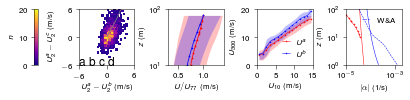

In [435]:
fig = plt.gcf()

ax0 = plt.subplot(141)

plt.plot(U0a-U0b,U0a-U0c,'grey',lw=lw*1.5)

hist = np.histogram2d(u0aca-u0bca,u0aca-u0cca,bins=[np.linspace(-6,6,40),np.linspace(-6,6,40)])
hist[0][hist[0]==0] = np.nan
s0 = plt.pcolormesh(hist[1],hist[2],hist[0].T,rasterized=True,vmin=0,vmax=20,cmap='plasma')

plt.xlabel('$U_{2}^a-U_{2}^b$ (m/s)',fontsize=fs)
plt.ylabel('$U_{2}^a-U_{2}^c$ (m/s)',fontsize=fs)

plt.xlim(-6,6)
plt.ylim(-6,6)
plt.gca().set_aspect('equal')

plt.xticks([-6,0,6],fontsize=fs)
plt.yticks([-6,0,6],fontsize=fs)

plt.text(-6,-6,'a b c d',fontsize=12)

ax1 = plt.subplot(142)

plt.plot(uavl1,z_l1[:-1],'-o',markersize=lw*1.5,lw=lw*1.5,c='r')
plt.fill_betweenx(z_l1[:-1],u25l1,u75l1,color='r',alpha=0.25,lw=0)

tempz = z_l2[:-1]
tempz[-1] = 77
plt.plot(uavl2,tempz,'-o',markersize=lw*1.5,lw=lw*1.5,c='b')
plt.fill_betweenx(tempz,u25l2,u75l2,color='b',alpha=0.25,lw=0)

plt.yscale('log')

plt.xlabel('$U/U_{77}$ (m/s)',fontsize=fs)
plt.ylabel('$z$ (m)',fontsize=fs)

plt.xlim(0.3,1.4)
plt.ylim(10**1,10**2)
ax1.yaxis.set_minor_formatter(NullFormatter())

plt.xticks(fontsize=fs)
plt.yticks([1e+1,1e+2],fontsize=fs)

ax2 = plt.subplot(143)

plt.plot(u1_la_binned,u11_l1a_binnedav,'-o',markersize=lw,lw=lw,c='r',label='$U^a$')
plt.plot(u1_la_binned,u11_l2a_binnedav,'-o',markersize=lw,lw=lw,c='b',label='$U^b$')

plt.fill_between(u1_la_binned,u11_l1a_binned25,u11_l1a_binned75,color='r',alpha=0.25,lw=0)
plt.fill_between(u1_la_binned,u11_l2a_binned25,u11_l2a_binned75,color='b',alpha=0.25,lw=0)

plt.xlabel('$U_{10}$ (m/s)',fontsize=fs)
plt.ylabel('$U_{300}$ (m/s)',fontsize=fs)
plt.legend(frameon=False,loc=0,handlelength=lw*2,fontsize=fs)

plt.xlim(0,15)
plt.ylim(0,20)

plt.xticks([0,5,10,15],fontsize=fs)
plt.yticks([0,10,20],fontsize=fs)

ax3 = plt.subplot(144)

plt.plot(al0_mbz,z_t,'r',markersize=lw,lw=lw)
plt.plot(al1_mbz,z_t,'b',markersize=lw,lw=lw)

plt.plot(a_l,z_l1[:-1],'-o',color='r',markersize=lw,lw=lw)
plt.plot(a_les,z_les,color='b',linestyle='--',markersize=lw,lw=lw,label='W\&A')

plt.xscale('log')
plt.yscale('log')

plt.xlabel('$|\\alpha|$ (1/s)',fontsize=fs)
plt.ylabel('$z$ (m)',fontsize=fs)
plt.legend(frameon=False,loc=1,handlelength=lw*2,fontsize=fs)

plt.xlim(1e-5,2e-3)
plt.ylim(1e+0,1e+2)

plt.xticks([1e-5,1e-3],fontsize=fs)
plt.yticks([1e+0,1e+1,1e+2],fontsize=fs)

fig.subplots_adjust(wspace=0.6)
fig.subplots_adjust(bottom=0.33)
fig.subplots_adjust(top=0.9)
fig.subplots_adjust(right=0.99)

fig.subplots_adjust(left=0.19)
cbar_ax = fig.add_axes([0.08, 0.33, 0.01, 0.57])
c0 = fig.colorbar(s0, cax=cbar_ax, ticks=[0,10,20])
cbar_ax.yaxis.set_label_position('left')
cbar_ax.yaxis.set_ticks_position('left')
c0.set_label('$n$',fontsize=fs)
c0.ax.set_yticklabels(['$0$','$10$','$20$'],fontsize=fs)

ax0.tick_params(width=lw)
for axis in ['top','bottom','left','right']:
    ax0.spines[axis].set_linewidth(lw) 
ax1.tick_params(width=lw)
for axis in ['top','bottom','left','right']:
    ax1.spines[axis].set_linewidth(lw) 
ax2.tick_params(width=lw)
for axis in ['top','bottom','left','right']:
    ax2.spines[axis].set_linewidth(lw)
ax3.tick_params(width=lw)
for axis in ['top','bottom','left','right']:
    ax3.spines[axis].set_linewidth(lw)
c0.ax.tick_params(width=lw)
c0.outline.set_linewidth(lw)

fig.set_size_inches(142.5/25.4, 142.5/25.4/4.15, forward=True)
plt.savefig('figures/fig3.pdf', dpi=300)

### new

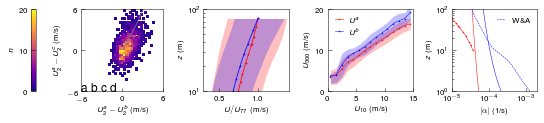

In [511]:
fig = plt.gcf()

ax0 = plt.subplot(141)

plt.plot(U0a-U0b,U0a-U0c,'grey',lw=lw*1.5)

hist = np.histogram2d(u0aca-u0bca,u0aca-u0cca,bins=[np.linspace(-6,6,40),np.linspace(-6,6,40)])
hist[0][hist[0]==0] = np.nan
s0 = plt.pcolormesh(hist[1],hist[2],hist[0].T,rasterized=True,vmin=0,vmax=20,cmap='plasma')

plt.xlabel('$U_{2}^a-U_{2}^b$ (m/s)',fontsize=fs)
plt.ylabel('$U_{2}^a-U_{2}^c$ (m/s)',fontsize=fs)

plt.xlim(-6,6)
plt.ylim(-6,6)
plt.gca().set_aspect('equal')

plt.xticks([-6,0,6],fontsize=fs)
plt.yticks([-6,0,6],fontsize=fs)

plt.text(-6,-6,'a b c d',fontsize=12)

ax1 = plt.subplot(142)

plt.plot(uavl1,z_l1[:-1],'-o',markersize=lw*1.5,lw=lw*1.5,c='r')
plt.fill_betweenx(z_l1[:-1],u25l1,u75l1,color='r',alpha=0.25,lw=0)

tempz = z_l2[:-1]
tempz[-1] = 77
plt.plot(uavl2,tempz,'-o',markersize=lw*1.5,lw=lw*1.5,c='b')
plt.fill_betweenx(tempz,u25l2,u75l2,color='b',alpha=0.25,lw=0)

plt.yscale('log')

plt.xlabel('$U/U_{77}$ (m/s)',fontsize=fs)
plt.ylabel('$z$ (m)',fontsize=fs)

plt.xlim(0.3,1.4)
plt.ylim(10**1,10**2)
ax1.yaxis.set_minor_formatter(NullFormatter())

plt.xticks(fontsize=fs)
plt.yticks([1e+1,1e+2],fontsize=fs)

ax2 = plt.subplot(143)

plt.plot(u1_la_binned,u11_l1a_binnedav,'-o',markersize=lw,lw=lw,c='r',label='$U^a$')
plt.plot(u1_la_binned,u11_l2a_binnedav,'-o',markersize=lw,lw=lw,c='b',label='$U^b$')

plt.fill_between(u1_la_binned,u11_l1a_binned25,u11_l1a_binned75,color='r',alpha=0.25,lw=0)
plt.fill_between(u1_la_binned,u11_l2a_binned25,u11_l2a_binned75,color='b',alpha=0.25,lw=0)

plt.xlabel('$U_{10}$ (m/s)',fontsize=fs)
plt.ylabel('$U_{300}$ (m/s)',fontsize=fs)
plt.legend(frameon=False,loc=0,handlelength=lw*2,fontsize=fs)

plt.xlim(0,15)
plt.ylim(0,20)

plt.xticks([0,5,10,15],fontsize=fs)
plt.yticks([0,10,20],fontsize=fs)

ax3 = plt.subplot(144)

plt.plot(al0_mbz,z_t,'r',markersize=lw,lw=lw)
plt.plot(al1_mbz,z_t,'b',markersize=lw,lw=lw)

plt.plot(a_l,z_l1[:-1],'-o',color='r',markersize=lw,lw=lw)
plt.plot(a_les,z_les,color='b',linestyle='--',markersize=lw,lw=lw,label='W\&A')

plt.xscale('log')
plt.yscale('log')

plt.xlabel('$|\\alpha|$ (1/s)',fontsize=fs)
plt.ylabel('$z$ (m)',fontsize=fs)
plt.legend(frameon=False,loc=1,handlelength=lw*2,fontsize=fs)

plt.xlim(1e-5,2e-3)
plt.ylim(1e+0,1e+2)

plt.xticks([1e-5,1e-4,1e-3],fontsize=fs)
plt.yticks([1e+0,1e+1,1e+2],fontsize=fs)

fig.subplots_adjust(wspace=0.45)
fig.subplots_adjust(bottom=0.22)
fig.subplots_adjust(top=0.93)
fig.subplots_adjust(right=0.99)

fig.subplots_adjust(left=0.14)
cbar_ax = fig.add_axes([0.05, 0.22, 0.01, 0.93-0.22])
c0 = fig.colorbar(s0, cax=cbar_ax, ticks=[0,10,20])
cbar_ax.yaxis.set_label_position('left')
cbar_ax.yaxis.set_ticks_position('left')
c0.set_label('$n$',fontsize=fs)
c0.ax.set_yticklabels(['$0$','$10$','$20$'],fontsize=fs)

ax0.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax0.spines[axis].set_linewidth(lw) 
ax1.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax1.spines[axis].set_linewidth(lw) 
ax2.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax2.spines[axis].set_linewidth(lw)
ax3.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax3.spines[axis].set_linewidth(lw)
c0.ax.tick_params(width=lw,which='both',direction='in')
c0.outline.set_linewidth(lw)

fig.set_size_inches(190/25.4, 142.5/25.4/3.5, forward=True)
plt.savefig('figures/fig3.pdf', dpi=300)

## Figure 4

### old

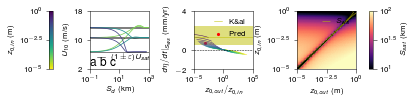

In [428]:
c=cm.viridis_r(np.linspace(0,1,Nz0))
lw=0.5
Np = 3
z0_i = np.linspace(0.2,0.8,Np)*Nz0
S = 10
A = 0.5

fig = plt.gcf()

ax0 = plt.subplot(131)
for i in z0_i.astype(int):
    for j in z0_i.astype(int):
        if i==j:
            ax0.plot([1e-1,1e+3],[U1[i,j,0],U1[i,j,0]],'k',lw=lw)
            ax0.fill_between([1e-1,1e+3],[(1-eps)*U1[i,j,0],(1-eps)*U1[i,j,0]],[(1+eps)*U1[i,j,0],(1+eps)*U1[i,j,0]],color='k',alpha=A,lw=0)
        else:
            ax0.plot(X1[i,j,:]*m2km,U1[i,j,:],c=c[i],lw=lw*1.5)
ax0.plot([0,0],[0,0],'k',lw=lw,label='$(1\\pm\\varepsilon)U_{sat}$')
plt.xscale('log')
plt.xlim(1e-1,1e+3)
plt.ylim(2,18)
plt.xticks(fontsize=fs)
plt.yticks([2,10,18],fontsize=fs)
plt.xlabel('$S_{d}$ (km)',fontsize=fs)
plt.ylabel('$U_{10}$ (m/s)',fontsize=fs)
plt.legend(frameon=False,handlelength=lw*2,fontsize=fs)
plt.text(1e-1,3,'a b c',fontsize=12)

ax1 = plt.subplot(132)
for i in np.arange(0,len(Z0r),4):
        plt.plot(Z0r[i,:],DZDTr[i,:]/s2y*m2mm,c=c[i],lw=lw)
# plt.fill_between([np.min(Z0r),np.max(Z0r)],[dzdtr_k0725,dzdtr_k0725],[dzdtr_k0775,dzdtr_k0775],color='y',alpha=A,lw=0)
plt.fill_between([np.min(Z0r),np.max(Z0r)],[dzdtr_k070,dzdtr_k070],[dzdtr_k07100,dzdtr_k07100],color='y',alpha=A,lw=0)
plt.plot([np.min(Z0r),np.max(Z0r)],[dzdtr_k07av,dzdtr_k07av],c='y',lw=lw,label='K\&al')
plt.scatter(Z0r[z0_1wsi,z0_0wsi],DZDTr_k07[z0_1wsi,z0_0wsi]/s2y*m2mm,c='r',s=S,lw=0,label='Pred')
plt.plot([np.min(Z0r),np.max(Z0r)],[0,0],'--k',lw=lw)
plt.xscale('log')
plt.xlim(np.min(Z0r),np.max(Z0r))
plt.ylim(-2,4)
plt.xticks([1e-5,1e+0,1e+5],fontsize=fs)
plt.yticks([-2,0,4],fontsize=fs)
plt.xlabel('$z_{0,out}/z_{0,in}$',fontsize=fs)
plt.ylabel('$d\\eta/dt|_{S_{ws}}$ (mm/yr)',fontsize=fs)
plt.legend(frameon=False,handlelength=lw*2,fontsize=fs)

ax1.yaxis.set_minor_formatter(NullFormatter())

ax2 = plt.subplot(133)
s1 = ax2.pcolormesh(Z0_0,Z0_1,np.log10(LSb*m2km),cmap='magma',vmin=1,vmax=2,rasterized=True)
s2 = ax2.contour(Z0_0,Z0_1,np.log10(LSb*m2km),[np.log10(s_r_m*m2km)],colors='y',linewidths=lw)
ax2.scatter(z00,z01,c='r',s=S,lw=0)
plt.xscale('log')
plt.yscale('log')
plt.xlim(np.min(Z0_0),np.max(Z0_0))
plt.ylim(np.min(Z0_1),np.max(Z0_1))
plt.xticks([1e-5,10**-2.5,1e+0],['$10^{-5}$','$10^{-2.5}$','$10^{0}$'],fontsize=fs)
plt.yticks([1e-5,10**-2.5,1e+0],['$10^{-5}$','$10^{-2.5}$','$10^{0}$'],fontsize=fs)
plt.xlabel('$z_{0,out}$ (m)',fontsize=fs)
plt.ylabel('$z_{0,in}$ (m)',fontsize=fs)
s2.collections[0].set_label('$S_{ws}$')
plt.legend(frameon=False,handlelength=lw*2,fontsize=fs)
    
ax2.yaxis.set_minor_formatter(NullFormatter())

fig.subplots_adjust(wspace=0.75)
fig.subplots_adjust(bottom=0.3)
fig.subplots_adjust(top=0.93)

s0 = plt.scatter([0],[0],c=[0],cmap='viridis_r',vmin=np.log10(np.min(z0_0)),vmax=np.log10(np.max(z0_0)))

fig.subplots_adjust(left=0.22)
cbar_ax = fig.add_axes([0.12, 0.3, 0.01, 0.63])
c0 = fig.colorbar(s0, cax=cbar_ax, ticks=[-5,-2.5,0])
cbar_ax.yaxis.set_label_position('left')
cbar_ax.yaxis.set_ticks_position('left')
c0.set_label('$z_{0,in}$ (m)',fontsize=fs)
c0.ax.set_yticklabels(['$10^{-5}$','$10^{-2.5}$','$10^{0}$'],fontsize=fs)

fig.subplots_adjust(right=0.88)
cbar_ax = fig.add_axes([0.91, 0.3, 0.01, 0.63])
c1 = fig.colorbar(s1, cax=cbar_ax, ticks=[1,1.5,2])
c1.set_label('$S_{sat}$ (km)',fontsize=fs)
c1.ax.set_yticklabels(['$10^{1}$','$10^{1.5}$','$10^{2}$'],fontsize=fs)

ax0.tick_params(width=lw)
for axis in ['top','bottom','left','right']:
    ax0.spines[axis].set_linewidth(lw)
ax1.tick_params(width=lw)
for axis in ['top','bottom','left','right']:
    ax1.spines[axis].set_linewidth(lw)
ax2.tick_params(width=lw)
for axis in ['top','bottom','left','right']:
    ax2.spines[axis].set_linewidth(lw)
c0.ax.tick_params(width=lw)
c0.outline.set_linewidth(lw)
c1.ax.tick_params(width=lw)
c1.outline.set_linewidth(lw)

fig.set_size_inches(142.5/25.4, 142.5/25.4/4.4, forward=True)
plt.savefig('figures/fig4.pdf', dpi=300)

### new

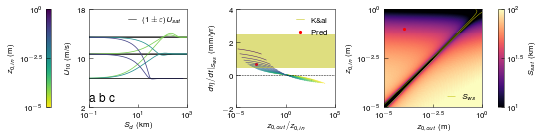

In [521]:
c=cm.viridis_r(np.linspace(0,1,Nz0))
lw=0.5
Np = 3
z0_i = np.linspace(0.2,0.8,Np)*Nz0
S = 10
A = 0.5

fig = plt.gcf()

ax0 = plt.subplot(131)
for i in z0_i.astype(int):
    for j in z0_i.astype(int):
        if i==j:
            ax0.plot([1e-1,1e+3],[U1[i,j,0],U1[i,j,0]],'k',lw=lw)
            ax0.fill_between([1e-1,1e+3],[(1-eps)*U1[i,j,0],(1-eps)*U1[i,j,0]],[(1+eps)*U1[i,j,0],(1+eps)*U1[i,j,0]],color='k',alpha=A,lw=0)
        else:
            ax0.plot(X1[i,j,:]*m2km,U1[i,j,:],c=c[i],lw=lw*1.5)
ax0.plot([0,0],[0,0],'k',lw=lw,label='$(1\\pm\\varepsilon)U_{sat}$')
plt.xscale('log')
plt.xlim(1e-1,1e+3)
plt.ylim(2,18)
plt.xticks(fontsize=fs)
plt.yticks([2,10,18],fontsize=fs)
plt.xlabel('$S_{d}$ (km)',fontsize=fs)
plt.ylabel('$U_{10}$ (m/s)',fontsize=fs)
plt.legend(frameon=False,handlelength=lw*2,fontsize=fs)
plt.text(1e-1,3,'a b c',fontsize=12)

ax1 = plt.subplot(132)
for i in np.arange(0,len(Z0r),4):
        plt.plot(Z0r[i,:],DZDTr[i,:]/s2y*m2mm,c=c[i],lw=lw)
# plt.fill_between([np.min(Z0r),np.max(Z0r)],[dzdtr_k0725,dzdtr_k0725],[dzdtr_k0775,dzdtr_k0775],color='y',alpha=A,lw=0)
plt.fill_between([np.min(Z0r),np.max(Z0r)],[dzdtr_k070,dzdtr_k070],[dzdtr_k07100,dzdtr_k07100],color='y',alpha=A,lw=0)
plt.plot([np.min(Z0r),np.max(Z0r)],[dzdtr_k07[0],dzdtr_k07[0]],c='y',lw=lw,label='K\&al')
plt.scatter(Z0r[z0_1wsi,z0_0wsi],DZDTr_k07[z0_1wsi,z0_0wsi]/s2y*m2mm,c='r',s=S,lw=0,label='Pred')
plt.plot([np.min(Z0r),np.max(Z0r)],[0,0],'--k',lw=lw)
plt.xscale('log')
plt.xlim(np.min(Z0r),np.max(Z0r))
plt.ylim(-2,4)
plt.xticks([1e-5,1e+0,1e+5],fontsize=fs)
plt.yticks([-2,0,2,4],fontsize=fs)
plt.xlabel('$z_{0,out}/z_{0,in}$',fontsize=fs)
plt.ylabel('$d\\eta/dt|_{S_{ws}}$ (mm/yr)',fontsize=fs)
plt.legend(frameon=False,handlelength=lw*2,fontsize=fs)

ax1.yaxis.set_minor_formatter(NullFormatter())

z00  = 1e-4 # roughness length of upwind
z01  = 1e-1 # roughness length of downwind

ax2 = plt.subplot(133)
s1 = ax2.pcolormesh(Z0_0,Z0_1,np.log10(LSb*m2km),cmap='magma',vmin=1,vmax=2,rasterized=True)
s2 = ax2.contour(Z0_0,Z0_1,np.log10(LSb*m2km),[np.log10(s_r_m*m2km)],colors='y',linewidths=lw)
ax2.scatter(z00,z01,c='r',s=S,lw=0)
plt.xscale('log')
plt.yscale('log')
plt.axis('square')
plt.xlim(np.min(Z0_0),np.max(Z0_0))
plt.ylim(np.min(Z0_1),np.max(Z0_1))
plt.xticks([1e-5,10**-2.5,1e+0],['$10^{-5}$','$10^{-2.5}$','$10^{0}$'],fontsize=fs)
plt.yticks([1e-5,10**-2.5,1e+0],['$10^{-5}$','$10^{-2.5}$','$10^{0}$'],fontsize=fs)
plt.xlabel('$z_{0,out}$ (m)',fontsize=fs)
plt.ylabel('$z_{0,in}$ (m)',fontsize=fs)
s2.collections[0].set_label('$S_{ws}$')
plt.legend(frameon=False,handlelength=lw*2,fontsize=fs,loc=4)
    
ax2.yaxis.set_minor_formatter(NullFormatter())

fig.subplots_adjust(wspace=0.5)
fig.subplots_adjust(bottom=0.2)
fig.subplots_adjust(top=0.93)

s0 = plt.scatter([0],[0],c=[0],cmap='viridis_r',vmin=np.log10(np.min(z0_0)),vmax=np.log10(np.max(z0_0)))

fig.subplots_adjust(left=0.16)
cbar_ax = fig.add_axes([0.08, 0.2, 0.01, 0.93-0.2])
c0 = fig.colorbar(s0, cax=cbar_ax, ticks=[-5,-2.5,0])
cbar_ax.yaxis.set_label_position('left')
cbar_ax.yaxis.set_ticks_position('left')
c0.set_label('$z_{0,in}$ (m)',fontsize=fs)
c0.ax.set_yticklabels(['$10^{-5}$','$10^{-2.5}$','$10^{0}$'],fontsize=fs)

fig.subplots_adjust(right=0.89)
cbar_ax = fig.add_axes([0.92, 0.2, 0.01, 0.93-0.2])
c1 = fig.colorbar(s1, cax=cbar_ax, ticks=[1,1.5,2])
c1.set_label('$S_{sat}$ (km)',fontsize=fs)
c1.ax.set_yticklabels(['$10^{1}$','$10^{1.5}$','$10^{2}$'],fontsize=fs)

ax0.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax0.spines[axis].set_linewidth(lw)
ax1.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax1.spines[axis].set_linewidth(lw)
ax2.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax2.spines[axis].set_linewidth(lw)
c0.ax.tick_params(width=lw,which='both',direction='in')
c0.outline.set_linewidth(lw)
c1.ax.tick_params(width=lw,which='both',direction='in')
c1.outline.set_linewidth(lw)

fig.set_size_inches(190/25.4, 142.5/25.4/3, forward=True)
plt.savefig('figures/fig4.pdf', dpi=300)

# Supplementary Figures

## Figure S1

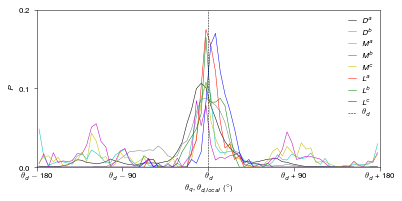

In [434]:
da = 5
mAf = np.arange(-180,180+da,da)
mAmidf = mAf[1:]-da/2

fig = plt.gcf()

ax0 = plt.subplot(111)

plt.plot(mAmidf,pq1_l1,lw=lw,c='k',label='$D^{a}$')
plt.plot(mAmidf,pq1_l2,lw=lw,c='grey',label='$D^{b}$')
plt.plot(mAmidf,pq2a,lw=lw,c='c',label='$M^{a}$')
plt.plot(mAmidf,pq2b,lw=lw,c='m',label='$M^{b}$')
plt.plot(mAmidf,pq2c,lw=lw,c='y',label='$M^{c}$')
plt.plot(ppd_bins-af0,pdd_jan09,lw=lw,c='r',label='$L^{a}$')
plt.plot(ppd_bins-af0,pdd_sep09,lw=lw,c='g',label='$L^{b}$')
plt.plot(ppd_bins-af0,pdd_jun10,lw=lw,c='b',label='$L^{c}$')
plt.plot([0,0],[0,0.2],'--k',lw=lw,label='$\\theta_{d}$')

plt.xlim(-180,180)
plt.ylim(0,0.2)
plt.xticks([-180,-90,0,90,180],['$\\theta_{d}-180$','$\\theta_{d}-90$','$\\theta_{d}$','$\\theta_{d}+90$','$\\theta_{d}+180$'],fontsize=fs)
plt.yticks([0,0.1,0.2],fontsize=fs)
plt.ylabel('$P$',fontsize=fs)
plt.xlabel('$\\theta_q,\\theta_{d,local}$ ($^{\\circ}$)',fontsize=fs)
plt.legend(frameon=False,handlelength=lw*2,fontsize=fs)

fig.subplots_adjust(bottom=0.18)
fig.subplots_adjust(top=0.96)
fig.subplots_adjust(right=0.95)
fig.subplots_adjust(left=0.1)

ax0.tick_params(width=lw)
for axis in ['top','bottom','left','right']:
    ax0.spines[axis].set_linewidth(lw)

fig.set_size_inches(142.5/25.4, 142.5/25.4/2, forward=True)
plt.savefig('figures/figS1.pdf', dpi=300)

## Figure S2

In [64]:
Xi2 = 3.81e+5
Xf2 = Xi2 + DS
Yi2 = 3.634e+6
Yf2 = Yi2 + DS

Xi2r =  (Xi2+DS/2)*np.cos(af0*np.pi/180)+(Yi2+DS/2)*np.sin(af0*np.pi/180) - DS/2
Xf2r =  Xi2r+DS
Yi2r = -(Xi2+DS/2)*np.sin(af0*np.pi/180)+(Yi2+DS/2)*np.cos(af0*np.pi/180) - DS/2
Yf2r =  Yi2r+DS

da = 1/2
abins = np.arange(-360-da,360+2*da,2*da)
abinmids = abins[1:] - da

ds = gdal.Open(jan09, gdal.GA_ReadOnly)
rb = ds.GetRasterBand(1)
metaxy = ds.GetGeoTransform()
z_jan09 = np.flip(rb.ReadAsArray(),axis=0)
x = metaxy[0]+metaxy[1]*np.arange(0,np.shape(z_jan09)[1])
y = np.flip(metaxy[3]+metaxy[5]*np.arange(0,np.shape(z_jan09)[0]))
X,Y = np.meshgrid(x,y)

ds = gdal.Open(jan09r, gdal.GA_ReadOnly)
rb = ds.GetRasterBand(1)
metaxy = ds.GetGeoTransform()
zr_jan09 = np.flip(rb.ReadAsArray(),axis=0)
zr_jan09[zr_jan09<0] = np.nan
xr = metaxy[0]+metaxy[1]*np.arange(0,np.shape(zr_jan09)[1])
yr = np.flip(metaxy[3]+metaxy[5]*np.arange(0,np.shape(zr_jan09)[0]))
Xr,Yr = np.meshgrid(xr,yr)

xi2 = np.argmin(np.abs(x-Xi2))
xf2 = np.argmin(np.abs(x-Xf2))
yi2 = np.argmin(np.abs(y-Yi2))
yf2 = np.argmin(np.abs(y-Yf2))

xi2r = np.argmin(np.abs(xr-Xi2r))
xf2r = np.argmin(np.abs(xr-Xf2r))
yi2r = np.argmin(np.abs(yr-Yi2r))
yf2r = np.argmin(np.abs(yr-Yf2r))

ae_jan09 = ae(z_jan09)
dzdy_jan09 = np.gradient(z_jan09,axis=0)

with open('DEMs/qs0.pkl', 'rb') as file:
    qs0 = pickle.load(file)
tempq = qs0[int((yi2r+yf2r)/2),xi2r:xf2r]

dzdt0c = demcorrect(dems[:-1],[dempairs[0]],demdts[:-1])
dzdt0c = np.squeeze(dzdt0c)

temp = ae_jan09[yi2:yf2,xi2:xf2]
tempa = temp[~np.isnan(temp)]
acnt,_ = np.histogram(tempa,bins=abins)
tempc = ridspuriousangles(acnt,abinmids)
p = correlate(tempc,np.flip(tempc),mode='same')
tempdd = abinmids[np.argmax(p)]/2

/home/andrew/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less
  
/home/andrew/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()


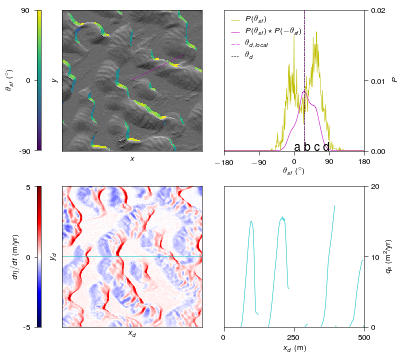

In [65]:
d0 = 2.5e+2
d1 = 2e+2
dzdtm = 5
lw = 0.5

fig = plt.gcf()

ax1 = plt.subplot(221)

s0 = ax1.pcolormesh(X[yi2:yf2,xi2:xf2],Y[yi2:yf2,xi2:xf2],dzdy_jan09[yi2:yf2,xi2:xf2],rasterized=True,cmap='binary')
s1 = ax1.pcolormesh(X[yi2:yf2,xi2:xf2],Y[yi2:yf2,xi2:xf2],ae_jan09[yi2:yf2,xi2:xf2],vmin=-90,vmax=90,rasterized=True)
ax1.plot([Xi2+d0,Xi2+d0+d1*np.cos(tempdd*np.pi/180)],[Yi2+d0,Yi2+d0+d1*np.sin(tempdd*np.pi/180)],'--m',lw=lw)
ax1.axis('equal')
plt.xticks([],[])
plt.yticks([],[])
ax1.set_xlabel('$x$',fontsize=fs)
ax1.set_ylabel('$y$',fontsize=fs)

ax2 = plt.subplot(223)

s2 = ax2.pcolormesh(Xr[yi2r:yf2r,xi2r:xf2r],Yr[yi2r:yf2r,xi2r:xf2r],dzdt0c[yi2r:yf2r,xi2r:xf2r]/s2y,vmin=-dzdtm,vmax=dzdtm,rasterized=True,cmap='seismic')
ax2.plot([Xi2r,Xf2r],[(Yi2r+Yf2r)/2,(Yi2r+Yf2r)/2],'c',lw=lw)
ax2.axis('equal')
plt.xticks([],[])
plt.yticks([],[])
ax2.set_xlabel('$x_d$',fontsize=fs)
ax2.set_ylabel('$y_d$',fontsize=fs)

ax3 = plt.subplot(222)

s3 = ax3.plot(abinmids,acnt/np.sum(acnt),c='y',lw=lw,label='$P(\\theta_{sf})$')
ax3.plot(abinmids/2,p/np.sum(p),c='m',lw=lw,label='$P(\\theta_{sf})\\star P(-\\theta_{sf})$')
ax3.plot([tempdd,tempdd],[0,1.2*np.max(acnt/np.sum(acnt))],'-.m',lw=lw,label='$\\theta_{d,local}$')
ax3.plot([af0,af0],[0,1.2*np.max(acnt/np.sum(acnt))],'--k',lw=lw,label='$\\theta_{d}$')

plt.legend(frameon=False,handlelength=lw*2,fontsize=fs)
plt.text(0,0,'a b c d',fontsize=12)

ax3.set_xlim(-180,180)
ax3.set_ylim(0,np.max(acnt/np.sum(acnt)))

ax3.yaxis.set_label_position("right")
ax3.yaxis.tick_right()

plt.xticks([-180,-90,0,90,180],['$-180$','$-90$','$0$','$90$','$180$'],fontsize=fs)
plt.yticks([0,0.01,0.02],fontsize=fs)

ax3.set_xlabel('$\\theta_{sf}$ ($^{\\circ}$)',fontsize=fs)
ax3.set_ylabel('$P$',fontsize=fs)

ax4 = plt.subplot(224)

ax4.plot(xr[xi2r:xf2r]-xr[xi2r]+20,tempq/s2y,c='c',lw=lw)

ax4.set_xlim(0,5e+2)
ax4.set_ylim(0,20)

ax4.yaxis.set_label_position("right")
ax4.yaxis.tick_right()

plt.xticks([0,250,500],fontsize=fs)
plt.yticks([0,10,20],fontsize=fs)

ax4.set_xlabel('$x_d$ (m)',fontsize=fs)
ax4.set_ylabel('$q_s$ (m$^2$/yr)',fontsize=fs)

fig.subplots_adjust(wspace=0.15)
fig.subplots_adjust(hspace=0.25)

fig.subplots_adjust(bottom=0.09)
fig.subplots_adjust(top=0.97)
fig.subplots_adjust(right=0.91)
fig.subplots_adjust(left=0.16)

cbar_ax1 = fig.add_axes([0.1, 0.58, 0.01, 0.39])
c1 = fig.colorbar(s1, cax=cbar_ax1, ticks=[-90,0,90])
cbar_ax1.yaxis.set_label_position('left')
cbar_ax1.yaxis.set_ticks_position('left')
c1.set_label('$\\theta_{sf}$ ($^{\\circ}$)',fontsize=fs)
c1.ax.set_yticklabels(['-90','0','90'],fontsize=fs)

cbar_ax2 = fig.add_axes([0.1, 0.09, 0.01, 0.39])
c2 = fig.colorbar(s2, cax=cbar_ax2, ticks=[-5,0,5])
cbar_ax2.yaxis.set_label_position('left')
cbar_ax2.yaxis.set_ticks_position('left')
c2.set_label('$d\\eta/dt$ (m/yr)',fontsize=fs)
c2.ax.set_yticklabels(['-5','0','5'],fontsize=fs)

ax1.tick_params(width=lw)
for axis in ['top','bottom','left','right']:
    ax1.spines[axis].set_linewidth(lw)
ax2.tick_params(width=lw)
for axis in ['top','bottom','left','right']:
    ax2.spines[axis].set_linewidth(lw)
ax3.tick_params(width=lw)
for axis in ['top','bottom','left','right']:
    ax3.spines[axis].set_linewidth(lw)
ax4.tick_params(width=lw)
for axis in ['top','bottom','left','right']:
    ax4.spines[axis].set_linewidth(lw)
c1.ax.tick_params(width=lw)
c1.outline.set_linewidth(lw)
c2.ax.tick_params(width=lw)
c2.outline.set_linewidth(lw)

fig.set_size_inches(142.5/25.4, 142.5/25.4/1.12,forward=True)
plt.savefig('figures/figS2.pdf',dpi=300)

## Figure S3

In [66]:
ds = gdal.Open(jun10r, gdal.GA_ReadOnly)
metaxy = ds.GetGeoTransform()

with open('DEMs/qs0.pkl', 'rb') as file:
    qs0 = pickle.load(file)
    
xr = metaxy[0]+metaxy[1]*np.arange(0,np.shape(qs0)[1])
yr = np.flip(metaxy[3]+metaxy[5]*np.arange(0,np.shape(qs0)[0]))
xr = metaxy[0]+metaxy[1]*np.arange(0,np.shape(qs0)[1])
yr = np.flip(metaxy[3]+metaxy[5]*np.arange(0,np.shape(qs0)[0]))
Xr,Yr = np.meshgrid(xr,yr)

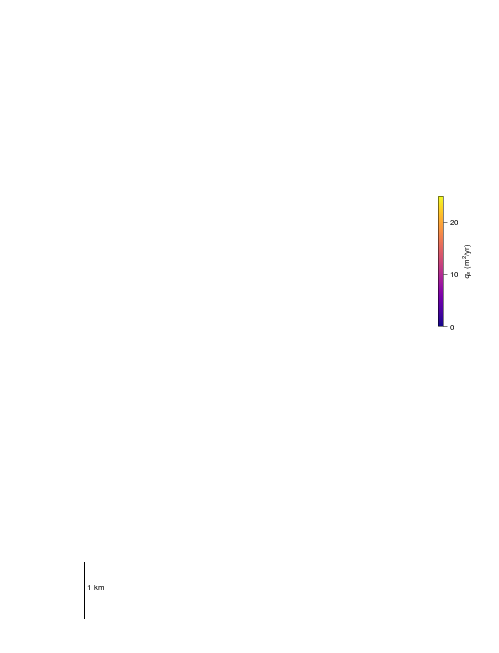

In [67]:
lw = 0.5

fig = plt.gcf()

ax0 = plt.subplot(111)

s = plt.pcolormesh(Yr*m2km,Xr*m2km,qs0/s2y,cmap='plasma',vmin=0,vmax=25,rasterized=True)

plt.plot([np.min(Yr[~np.isnan(qs0)]*m2km),np.min(Yr[~np.isnan(qs0)]*m2km)],[np.min(Xr[~np.isnan(qs0)]*m2km)+0.5,np.min(Xr[~np.isnan(qs0)]*m2km)+1+0.5],'k',lw=2*lw)
plt.text(np.min(Yr[~np.isnan(qs0)]*m2km)+0.05,np.min(Xr[~np.isnan(qs0)]*m2km)+0.5+0.5,'1 km',fontsize=fs)

ax0.axis('equal')

plt.ylabel('$x_d$ (km)',fontsize=fs)
plt.xlabel('$y_d$ (km)',fontsize=fs)

plt.ylim(np.min(Xr[~np.isnan(qs0)]*m2km),np.max(Xr[~np.isnan(qs0)]*m2km))
plt.xlim(np.min(Yr[~np.isnan(qs0)]*m2km),np.max(Yr[~np.isnan(qs0)]*m2km))

plt.axis('off')

fig.subplots_adjust(bottom=0.01)
fig.subplots_adjust(top=0.99)
fig.subplots_adjust(right=0.95)
fig.subplots_adjust(left=0.05)

cbar_ax = fig.add_axes([0.85, 0.5, 0.01, 0.2])
c = plt.colorbar(s, cax=cbar_ax, ticks=[0, 10, 20])
c.set_label('$q_s$ (m$^2$/yr)',fontsize=fs)
c.ax.set_yticklabels(['0','10','20'],fontsize=fs)
c.ax.tick_params(width=lw)
c.outline.set_linewidth(lw)

fig.set_size_inches(190/25.4, 230/25.4, forward=True)
plt.savefig('figures/figS3.pdf',dpi=300)

## Figure S4

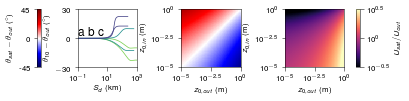

In [68]:
c=cm.viridis_r(np.linspace(0,1,Nz0))
lw=0.5
Np = 3
z0_i = np.linspace(0.2,0.8,Np)*Nz0
S = 10
A = 0.5

fig = plt.gcf()

ax0 = plt.subplot(131)
for i in z0_i.astype(int):
    for j in z0_i.astype(int):
        if i==j:
            continue
        else:
            ax0.plot(X1[i,j,:]*m2km,dT[i,j,:],c=c[i],lw=lw*1.5)
plt.xscale('log')
plt.xlim(1e-1,1e+3)
plt.ylim(-30,30)
plt.xticks(fontsize=fs)
plt.yticks([-30,0,30],fontsize=fs)
plt.xlabel('$S_{d}$ (km)',fontsize=fs)
plt.ylabel('$\\theta_{10}-\\theta_{out}$ ($^{\\circ}$)',fontsize=fs)
plt.text(1e-1,3,'a b c',fontsize=12)

ax1 = plt.subplot(132)
s1 = ax1.pcolormesh(Z0_0,Z0_1,Asat*180/np.pi,cmap='seismic',vmin=-45,vmax=45,rasterized=True)
ax2.scatter(z00,z01,c='r',s=S,lw=0)
plt.xscale('log')
plt.yscale('log')
plt.xlim(np.min(Z0_0),np.max(Z0_0))
plt.ylim(np.min(Z0_1),np.max(Z0_1))
plt.xticks([1e-5,10**-2.5,1e+0],['$10^{-5}$','$10^{-2.5}$','$10^{0}$'],fontsize=fs)
plt.yticks([1e-5,10**-2.5,1e+0],['$10^{-5}$','$10^{-2.5}$','$10^{0}$'],fontsize=fs)
plt.xlabel('$z_{0,out}$ (m)',fontsize=fs)
plt.ylabel('$z_{0,in}$ (m)',fontsize=fs)

ax2 = plt.subplot(133)
s2 = ax2.pcolormesh(Z0_0,Z0_1,np.log10(Usat),cmap='magma',vmin=-0.5,vmax=0.5,rasterized=True)
plt.xscale('log')
plt.yscale('log')
plt.xlim(np.min(Z0_0),np.max(Z0_0))
plt.ylim(np.min(Z0_1),np.max(Z0_1))
plt.xticks([1e-5,10**-2.5,1e+0],['$10^{-5}$','$10^{-2.5}$','$10^{0}$'],fontsize=fs)
plt.yticks([1e-5,10**-2.5,1e+0],['$10^{-5}$','$10^{-2.5}$','$10^{0}$'],fontsize=fs)
plt.xlabel('$z_{0,out}$ (m)',fontsize=fs)
plt.ylabel('$z_{0,in}$ (m)',fontsize=fs)

fig.subplots_adjust(wspace=0.75)
fig.subplots_adjust(bottom=0.3)
fig.subplots_adjust(top=0.93)

fig.subplots_adjust(left=0.19)
cbar_ax = fig.add_axes([0.09, 0.3, 0.01, 0.63])
c0 = fig.colorbar(s1, cax=cbar_ax, ticks=[-45,0,45])
cbar_ax.yaxis.set_label_position('left')
cbar_ax.yaxis.set_ticks_position('left')
c0.set_label('$\\theta_{sat}-\\theta_{out}$ ($^{\\circ}$)',fontsize=fs)
c0.ax.set_yticklabels(['-45','0','45'],fontsize=fs)

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.3, 0.01, 0.63])
c1 = fig.colorbar(s2, cax=cbar_ax, ticks=[-0.5,0,0.5])
c1.set_label('$U_{sat}/U_{out}$ ',fontsize=fs)
c1.ax.set_yticklabels(['$10^{-0.5}$','$10^{0}$','$10^{0.5}$'],fontsize=fs)

ax0.tick_params(width=lw)
for axis in ['top','bottom','left','right']:
    ax0.spines[axis].set_linewidth(lw)
ax1.tick_params(width=lw)
for axis in ['top','bottom','left','right']:
    ax1.spines[axis].set_linewidth(lw)
ax2.tick_params(width=lw)
for axis in ['top','bottom','left','right']:
    ax2.spines[axis].set_linewidth(lw)
c0.ax.tick_params(width=lw)
c0.outline.set_linewidth(lw)
c1.ax.tick_params(width=lw)
c1.outline.set_linewidth(lw)

fig.set_size_inches(142.5/25.4, 142.5/25.4/4.4, forward=True)
plt.savefig('figures/figS4.pdf', dpi=300)

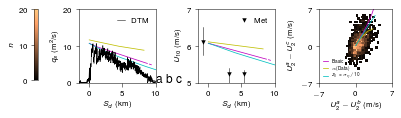

In [431]:
A = 1
S = 20

fig = plt.gcf()

ax0 = plt.subplot(131)

ax0.plot(X_t*m2km,Q_t/s2y,'m',lw=lw*1.5)
ax0.plot(X_t*m2km,Q_t_SR/s2y,'c',lw=lw*1.5)
ax0.plot(X_t*m2km,Q_t_DD/s2y,'y',lw=lw*1.5)

ax0.plot(sr*m2km,qavg[2]/s2y,c='k',lw=lw,label='DTM')

plt.text(10,0,'a b c',fontsize=12)


plt.xlabel('$S_d$ (km)',fontsize=fs)
plt.ylabel('$q_s$ (m$^2$/s)',fontsize=fs)

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.xlim(-1.5,10)
plt.ylim(0,20)

plt.xticks([0,5,10],fontsize=fs)
plt.yticks([0,10,20],fontsize=fs)

plt.legend(frameon=False,handlelength=lw*2,fontsize=fs)

ax1 = plt.subplot(132)

ax1.plot(X_t*m2km,U_t,'m',lw=lw*1.5)
ax1.plot(X_t*m2km,U_t_SR,'c',lw=lw*1.5)
ax1.plot(X_t*m2km,U_t_DD,'y',lw=lw*1.5)

ax1.scatter([s_a_o*m2km,s_b_o*m2km,s_c_o*m2km],[np.mean(u2aca),np.mean(u2bca),np.mean(u2cca)],c='k',marker='v',s=S,alpha=A,lw=0,label='Met')

ax1.plot([s_a_o*m2km,s_a_o*m2km],[np.percentile(u2aca,45),np.percentile(u2aca,55)],c='k',alpha=A,lw=lw)
ax1.plot([s_b_o*m2km,s_b_o*m2km],[np.percentile(u2bca,45),np.percentile(u2bca,55)],c='k',alpha=A,lw=lw)
ax1.plot([s_c_o*m2km,s_c_o*m2km],[np.percentile(u2cca,45),np.percentile(u2cca,55)],c='k',alpha=A,lw=lw)

plt.xlabel('$S_d$ (km)',fontsize=fs)
plt.ylabel('$U_{10}$ (m/s)',fontsize=fs)

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.legend(frameon=False,handlelength=lw*2,fontsize=fs)

plt.xlim(-1.5,10)
plt.ylim(5,7)

plt.xticks([0,5,10],fontsize=fs)
plt.yticks([5,6,7],fontsize=fs)

ax2 = plt.subplot(133)

ax2.plot(U0a-U0b,U0a-U0c,'m',lw=lw*1.5,label='Basic')
ax2.plot(U0a_DD-U0b_DD,U0a_DD-U0c_DD,'y',lw=lw*1.5,label='$\\alpha$(Data)')
ax2.plot(U0a_SR-U0b_SR,U0a_SR-U0c_SR,'c',lw=lw*1.5,label='$z_0=\sigma_\eta/10$')

hist = np.histogram2d(u0aca-u0bca,u0aca-u0cca,bins=[np.linspace(-6,6,40),np.linspace(-6,6,40)])
hist[0][hist[0]==0] = np.nan
s0 = plt.pcolormesh(hist[1],hist[2],hist[0].T,rasterized=True,vmin=0,vmax=20,cmap='copper')

plt.xlabel('$U_{2}^a-U_{2}^b$ (m/s)',fontsize=fs)
plt.ylabel('$U_{2}^a-U_{2}^c$ (m/s)',fontsize=fs)

plt.xlim(-7,7)
plt.ylim(-7,7)
plt.gca().set_aspect('equal')

plt.xticks([-7,0,7],fontsize=fs)
plt.yticks([-7,0,7],fontsize=fs)

plt.legend(frameon=False,handlelength=lw*2,fontsize=fs*0.6,loc=3)

fig.subplots_adjust(wspace=0.55)
fig.subplots_adjust(bottom=0.28)
fig.subplots_adjust(right=0.97)
fig.subplots_adjust(top=0.95)

fig.subplots_adjust(left=0.19)
cbar_ax = fig.add_axes([0.08, 0.3, 0.01, 0.65])
c0 = fig.colorbar(s0, cax=cbar_ax, ticks=[0,10,20])
cbar_ax.yaxis.set_label_position('left')
cbar_ax.yaxis.set_ticks_position('left')
c0.set_label('$n$',fontsize=fs)
c0.ax.set_yticklabels(['$0$','$10$','$20$'],fontsize=fs)

ax0.tick_params(width=lw)
for axis in ['top','bottom','left','right']:
    ax0.spines[axis].set_linewidth(lw) 
ax1.tick_params(width=lw)
for axis in ['top','bottom','left','right']:
    ax1.spines[axis].set_linewidth(lw) 
ax2.tick_params(width=lw)
for axis in ['top','bottom','left','right']:
    ax2.spines[axis].set_linewidth(lw)
c0.ax.tick_params(width=lw)
c0.outline.set_linewidth(lw)

fig.set_size_inches(142.5/25.4, 142.5/25.4/3.7, forward=True)
plt.savefig('figures/figS5.pdf', dpi=300)